# Quebec Plex Properties: Investment Analysis & Predictive Modeling

This notebook provides a comprehensive analysis of Quebec plex properties with the following objectives:

## Analysis Framework
1. **Data Exploration** - Distribution patterns, outliers, and market characteristics
2. **Variable Transformations** - Testing log, square, and polynomial transformations for better model fit
3. **Investment Opportunities** - Identifying undervalued properties using multiple scoring criteria
4. **Predictive Modeling** - Building robust price prediction models with feature selection
5. **Market Insights** - Geographic patterns and revenue optimization strategies

## Key Metrics Analyzed
- **Revenue Yield**: Annual income / Property price
- **Price per Unit**: Property value efficiency
- **Discount Score**: Multi-factor undervaluation indicator
- **Geographic Patterns**: Location-based market trends

## 1. Data Loading and Initial Exploration

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations
from step_criterion import step_criterion
from scipy import stats

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Setup paths and configuration
import os
import sys
UTILS_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'utils'))
if UTILS_PATH not in sys.path:
    sys.path.insert(0, UTILS_PATH)

# Import configuration and data preparation
from config import get_config, print_config
from data_preparation import prepare_plex_data, get_feature_groups, prepare_modeling_variables, create_formula_scope

# Set style for better plots
plt.style.use('seaborn-v0_8-deep')
sns.set_palette("husl")

# Load configuration
config = get_config()
print(f"Configuration loaded successfully for {config['target_year']} analysis")
print(f"Data source: {config['data_path'].split('/')[-1]}")
print(f"Assessment growth rate: {config['assessment_growth_rate']:.1%}")

Configuration loaded successfully for 2025 analysis
Data source: centris_comprehensive_plex_data.csv
Assessment growth rate: 5.7%


In [2]:
# Load and inspect raw data
df = pd.read_csv(config['data_path'])

print(f"Raw dataset: {df.shape[0]:,} properties, {df.shape[1]} features")
print(f"Key columns: {', '.join(df.columns[:8])}{'...' if len(df.columns) > 8 else ''}")

# Quick data quality check
missing_pct = (df.isnull().sum() / len(df) * 100).round(1)
high_missing = missing_pct[missing_pct > 20]
if len(high_missing) > 0:
    print(f"\nColumns with >20% missing data: {len(high_missing)} columns")
else:
    print(f"\nData quality: Good (no columns with >20% missing data)")

Raw dataset: 2,839 properties, 47 features
Key columns: listing_url, image_url, mls, scrape_date, category, address, description, lat...

Columns with >20% missing data: 14 columns


In [3]:
# Check for MLS numbers and property identifiers
print("Checking for property identifiers...")
print(f"DataFrame index name: {df.index.name}")
print(f"DataFrame index values (first 10): {df.index[:10].tolist()}")

# Look for MLS or ID columns
mls_related_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['mls', 'listing', 'id', 'number'])]
print(f"Potential MLS/ID columns: {mls_related_cols}")

if mls_related_cols:
    for col in mls_related_cols:
        print(f"\n{col} sample values: {df[col].head(10).tolist()}")
        print(f"{col} unique count: {df[col].nunique()}")

# Check if index contains MLS numbers
if df.index.name and 'mls' in df.index.name.lower():
    print(f"\nMLS numbers are in the index: {df.index.name}")
elif any(str(idx).isdigit() and len(str(idx)) >= 7 for idx in df.index[:10]):
    print("\nIndex appears to contain MLS-style numbers")

Checking for property identifiers...
DataFrame index name: None
DataFrame index values (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Potential MLS/ID columns: ['listing_url', 'mls', 'municipality_id', 'units_residential_breakdown', 'units_residential_raw']

listing_url sample values: ['https://www.centris.ca/fr/quadruplex~a-vendre~l-epiphanie/12989004?uc=1', 'https://www.centris.ca/fr/quintuplex~a-vendre~saint-hyacinthe/26370140?uc=1', 'https://www.centris.ca/fr/quadruplex~a-vendre~matane/28133932?uc=1', 'https://www.centris.ca/fr/duplex~a-vendre~quebec-sainte-foy-sillery-cap-rouge/10411765?uc=1', 'https://www.centris.ca/fr/triplex~a-vendre~salaberry-de-valleyfield/16861325?uc=1', 'https://www.centris.ca/fr/triplex~a-vendre~shawinigan/26587402?uc=1', 'https://www.centris.ca/fr/triplex~a-vendre~montreal-ahuntsic-cartierville/16235448?uc=1', 'https://www.centris.ca/fr/triplex~a-vendre~saint-hyacinthe/17389702?uc=1', 'https://www.centris.ca/fr/duplex~a-vendre~sainte-christine/18042732?uc=1',

In [4]:
# Basic statistics
df.describe()

mls          lat          lng       price_raw         price  \
count  2.839000e+03  2839.000000  2839.000000     2839.000000  2.839000e+03   
mean   1.894385e+07    46.035351   -73.099749   617851.655160  6.249073e+05   
std    5.730669e+06     0.889588     1.804430   238981.957137  2.423228e+05   
min    9.000579e+06    45.007444   -79.485043    85000.000000  8.500000e+04   
25%    1.389540e+07    45.496702   -73.761275   409450.000000  4.190000e+05   
50%    1.887004e+07    45.624722   -73.548941   629000.000000  6.390000e+05   
75%    2.382201e+07    46.265094   -72.425544   825000.000000  8.390000e+05   
max    2.898966e+07    50.208644   -61.835319  1000000.000000  1.149950e+06   

       rooms  bedrooms  full_baths  powder_rooms   year_built  ...  \
count    0.0       0.0         0.0           0.0  2669.000000  ...   
mean     NaN       NaN         NaN           NaN  1952.245785  ...   
std      NaN       NaN         NaN           NaN    34.820092  ...   
min      NaN       NaN         NaN           NaN  1730.000000  ...   
25%      NaN       NaN         NaN           NaN  1930.000000  ...   
50%      NaN       NaN         NaN           NaN  1954.000000  ...   
75%      NaN       NaN         NaN           NaN  1969.000000  ...   
max      NaN       NaN         NaN           NaN  2025.000000  ...   

       assessment_land  assessment_building  assessment_total  \
count      2717.000000         2.722000e+03      2.727000e+03   
mean     145546.975709         3.134360e+05      4.578745e+05   
std      101026.472678         1.523083e+05      2.203157e+05   
min         100.000000         1.000000e+02      2.000000e+02   
25%       61400.000000         1.944000e+05      2.792000e+05   
50%      130600.000000         2.867000e+05      4.347000e+05   
75%      211800.000000         4.162000e+05      6.199500e+05   
max      597000.000000         1.164600e+06      1.388500e+06   

       tax_municipal_year  tax_school_year  tax_municipal   tax_school  \
count         2795.000000      2795.000000    2772.000000  2760.000000   
mean          2024.869052      2024.541324    4492.999639   339.805435   
std              0.358990         0.554792    1819.333083   245.760890   
min           2022.000000      2022.000000     100.000000    10.000000   
25%           2025.000000      2024.000000    3300.750000   188.000000   
50%           2025.000000      2025.000000    4181.000000   300.000000   
75%           2025.000000      2025.000000    5229.000000   457.000000   
max           2026.000000      2026.000000   23090.000000  4794.000000   

          tax_total  expenses_total  expense_electricity  
count   2788.000000      841.000000           390.000000  
mean    4810.786227     3788.707491          2907.810256  
std     1931.692165     2921.309514          1831.753571  
min       52.000000       21.000000           166.000000  
25%     3541.500000     1953.000000          1397.500000  
50%     4515.500000     3068.000000          2597.000000  
75%     5691.000000     4774.000000          3954.250000  
max    23831.000000    24028.000000         10300.000000  

[8 rows x 31 columns]

## 2. Data Cleaning and Feature Engineering

In [5]:
# Prepare data using centralized preparation function with MLS preservation
print("Preserving MLS numbers as property identifiers...")

# Set MLS as index before data preparation
df_with_mls = df.set_index('mls', drop=False)  # Keep mls column and set as index
print(f"MLS numbers preserved as index for {len(df_with_mls)} properties")

data, scaler = prepare_plex_data(
    df=df_with_mls,
    target_year=config['target_year'],
    assessment_growth_rate=config['assessment_growth_rate'], 
    standardize=False,  # Keep original scale for exploration
    drop_original_geo=False  # Keep geographic data for mapping
)

# Ensure MLS is preserved in the prepared dataset
if 'mls' not in data.columns and data.index.name != 'mls':
    # If MLS was lost, restore it from the original dataframe
    data['mls'] = data.index
    print("MLS numbers restored to dataset")

# Add clean category labels
def categorize_units(units):
    if units == 2: return "Duplex"
    elif units == 3: return "Triplex"
    elif units == 4: return "Quadruplex"
    elif units == 5: return "Quintuplex"
    elif units == 6: return "Sixplex"
    elif units > 6: return f"{int(units)}-plex"
    else: return "Other"

data['category_clean'] = data['units_count'].apply(categorize_units)

# Get feature groups for organized analysis
feature_groups = get_feature_groups(data)

print(f"Data prepared: {data.shape[0]:,} properties retained ({100*data.shape[0]/df.shape[0]:.1f}% of original)")
print(f"Key metrics created: revenue_yield, price_per_unit, property_age")
print(f"MLS numbers preserved: {'✓ Yes' if 'mls' in data.columns or data.index.name == 'mls' else '✗ No'}")
print(f"Feature groups: {list(feature_groups.keys())}")

# Summary of property types
print(f"\nProperty distribution:")
for ptype, count in data['category_clean'].value_counts().head().items():
    print(f"  {ptype}: {count:,} ({100*count/len(data):.1f}%)")

# Show sample MLS numbers to verify preservation
if data.index.name == 'mls':
    print(f"\nSample MLS numbers (from index): {data.index[:5].tolist()}")
elif 'mls' in data.columns:
    print(f"\nSample MLS numbers (from column): {data['mls'].head(5).tolist()}")
else:
    print("\n⚠ Warning: MLS numbers may not be properly preserved")

Preserving MLS numbers as property identifiers...
MLS numbers preserved as index for 2839 properties
Adjusting assessment values to 2025 using 5.7% annual growth...
Standardizing building style labels...
Creating geographic features...
Standardizing building style labels...
Creating geographic features...
Encoding building styles...
Creating financial and property features...
New features created: ['revenue_yield', 'price_per_unit', 'price_per_sqft', 'income_per_unit', 'property_age', 'distance_from_mtl', 'Detached', 'Row', 'Semi_detached']
Data prepared: 2,839 properties retained (100.0% of original)
Key metrics created: revenue_yield, price_per_unit, property_age
MLS numbers preserved: ✓ Yes
Feature groups: ['core', 'financial', 'geographic', 'building_styles', 'derived']

Property distribution:
  Duplex: 1,401 (49.3%)
  Triplex: 886 (31.2%)
  Quadruplex: 414 (14.6%)
  Quintuplex: 124 (4.4%)
  Other: 7 (0.2%)

Sample MLS numbers (from index): [12989004, 26370140, 28133932, 10411765, 

In [6]:
# Key financial metrics summary
financial_metrics = ['price', 'gross_potential_income', 'revenue_yield', 'price_per_unit']
available_metrics = [col for col in financial_metrics if col in data.columns]

print("Financial Metrics Summary:")
summary_stats = data[available_metrics].describe()
print(summary_stats.round(0))

# Data completeness check
print(f"\nData Completeness:")
for col in available_metrics:
    missing = data[col].isna().sum()
    print(f"  {col}: {100*(1-missing/len(data)):.1f}% complete")

# Market overview
print(f"\nMarket Overview:")
print(f"  Price range: ${data['price'].min():,.0f} - ${data['price'].max():,.0f}")
print(f"  Revenue yield range: {data['revenue_yield'].min():.1f}% - {data['revenue_yield'].max():.1f}%")
print(f"  Median revenue yield: {data['revenue_yield'].median():.2f}%")

Financial Metrics Summary:
           price  gross_potential_income  revenue_yield  price_per_unit
count     2839.0                  2826.0         2826.0          2839.0
mean    624907.0                 37170.0            6.0        243320.0
std     242323.0                 15301.0            2.0        108674.0
min      85000.0                    24.0            0.0         34000.0
25%     419000.0                 26160.0            5.0        158333.0
50%     639000.0                 36930.0            6.0        238000.0
75%     839000.0                 47238.0            7.0        312500.0
max    1149950.0                130000.0           23.0        910000.0

Data Completeness:
  price: 100.0% complete
  gross_potential_income: 99.5% complete
  revenue_yield: 99.5% complete
  price_per_unit: 100.0% complete

Market Overview:
  Price range: $85,000 - $1,149,950
  Revenue yield range: 0.0% - 23.0%
  Median revenue yield: 6.00%
  Median revenue yield: 6.00%


## 4. Market Distribution Analysis

## 3. Variable Transformations & Feature Engineering

Testing log, square, and polynomial transformations to improve model performance, particularly for revenue variables.

In [7]:
# Test transformations for key revenue variables
def test_transformations(data, target_var='price', feature_var='gross_potential_income'):
    """Test different transformations and return R² scores"""
    
    # Clean data for analysis
    clean_data = data[[target_var, feature_var]].dropna()
    X = clean_data[[feature_var]]
    y = clean_data[target_var]
    
    # Test different transformations
    transformations = {}
    
    # Original (linear)
    model = LinearRegression().fit(X, y)
    transformations['Linear'] = model.score(X, y)
    
    # Log transformation (add small constant to avoid log(0))
    X_log = np.log(X + 1)
    model_log = LinearRegression().fit(X_log, y)
    transformations['Log(X)'] = model_log.score(X_log, y)
    
    # Square transformation
    X_sq = X ** 2
    model_sq = LinearRegression().fit(X_sq, y)
    transformations['X²'] = model_sq.score(X_sq, y)
    
    # Square root transformation
    X_sqrt = np.sqrt(X)
    model_sqrt = LinearRegression().fit(X_sqrt, y)
    transformations['√X'] = model_sqrt.score(X_sqrt, y)
    
    # Polynomial (degree 2)
    X_poly = np.column_stack([X, X**2])
    model_poly = LinearRegression().fit(X_poly, y)
    transformations['Polynomial (X + X²)'] = model_poly.score(X_poly, y)
    
    # Log-log transformation
    y_log = np.log(y + 1)
    model_loglog = LinearRegression().fit(X_log, y_log)
    transformations['Log-Log'] = model_loglog.score(X_log, y_log)
    
    return transformations

# Test transformations for revenue vs price relationship
print("Testing Variable Transformations for Revenue → Price Prediction")
print("=" * 60)

revenue_transforms = test_transformations(data, 'price', 'gross_potential_income')
print("\nGross Potential Income → Price:")
for transform, r2 in sorted(revenue_transforms.items(), key=lambda x: x[1], reverse=True):
    print(f"  {transform:20}: R² = {r2:.4f}")

# Test for other key relationships
if 'living_area_sqft' in data.columns:
    area_transforms = test_transformations(data, 'price', 'living_area_sqft')
    print(f"\nLiving Area → Price:")
    for transform, r2 in sorted(area_transforms.items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  {transform:20}: R² = {r2:.4f}")

# Create transformed variables for best performing transformations
best_revenue_transform = max(revenue_transforms.items(), key=lambda x: x[1])
print(f"\nBest transformation: {best_revenue_transform[0]} (R² = {best_revenue_transform[1]:.4f})")

# Add transformed variables to dataset
data['log_revenue'] = np.log(data['gross_potential_income'] + 1)
data['revenue_squared'] = data['gross_potential_income'] ** 2
data['log_price'] = np.log(data['price'] + 1)

print(f"\nTransformed variables added to dataset:")
print(f"  log_revenue, revenue_squared, log_price")

Testing Variable Transformations for Revenue → Price Prediction

Gross Potential Income → Price:
  Polynomial (X + X²) : R² = 0.5030
  Linear              : R² = 0.4845
  √X                  : R² = 0.4693
  X²                  : R² = 0.3795
  Log-Log             : R² = 0.2936
  Log(X)              : R² = 0.2912

Best transformation: Polynomial (X + X²) (R² = 0.5030)

Transformed variables added to dataset:
  log_revenue, revenue_squared, log_price

Gross Potential Income → Price:
  Polynomial (X + X²) : R² = 0.5030
  Linear              : R² = 0.4845
  √X                  : R² = 0.4693
  X²                  : R² = 0.3795
  Log-Log             : R² = 0.2936
  Log(X)              : R² = 0.2912

Best transformation: Polynomial (X + X²) (R² = 0.5030)

Transformed variables added to dataset:
  log_revenue, revenue_squared, log_price


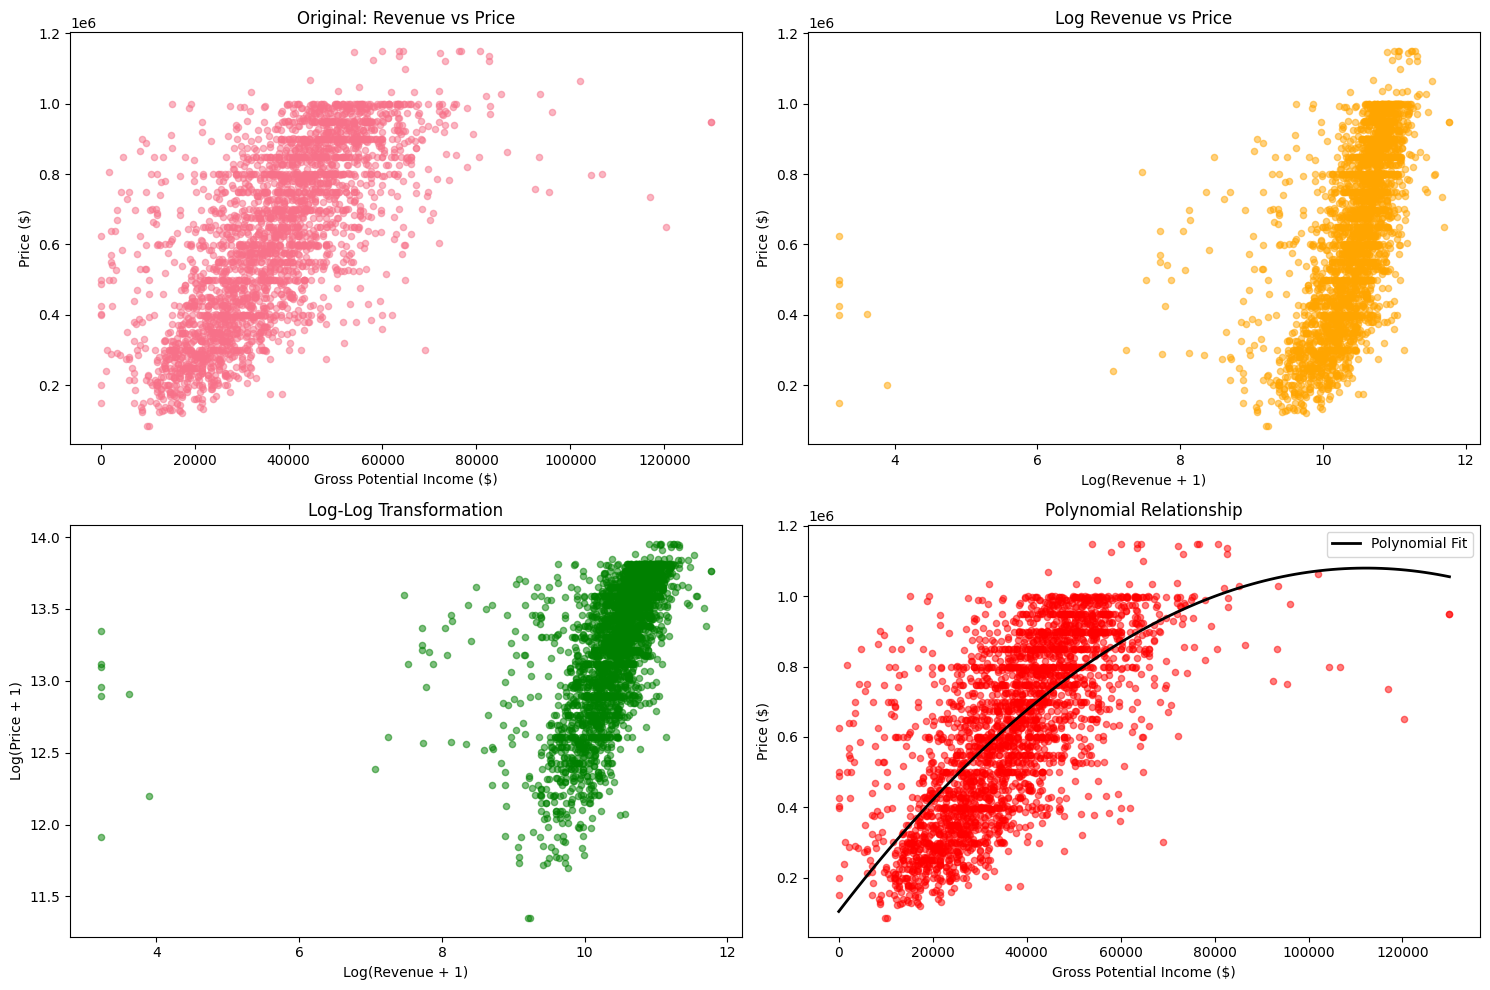

Transformation Analysis Summary:
  Original linear model R² = 0.4845
  Best transformation R² = 0.5030
  Improvement: +1.86 percentage points


In [8]:
# Visualize the best transformations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original relationship
axes[0,0].scatter(data['gross_potential_income'], data['price'], alpha=0.5, s=20)
axes[0,0].set_title('Original: Revenue vs Price')
axes[0,0].set_xlabel('Gross Potential Income ($)')
axes[0,0].set_ylabel('Price ($)')

# Log transformation
axes[0,1].scatter(data['log_revenue'], data['price'], alpha=0.5, s=20, color='orange')
axes[0,1].set_title('Log Revenue vs Price')
axes[0,1].set_xlabel('Log(Revenue + 1)')
axes[0,1].set_ylabel('Price ($)')

# Log-log transformation
axes[1,0].scatter(data['log_revenue'], data['log_price'], alpha=0.5, s=20, color='green')
axes[1,0].set_title('Log-Log Transformation')
axes[1,0].set_xlabel('Log(Revenue + 1)')
axes[1,0].set_ylabel('Log(Price + 1)')

# Polynomial relationship visualization
revenue_clean = data['gross_potential_income'].dropna()
price_clean = data.loc[revenue_clean.index, 'price']
z = np.polyfit(revenue_clean, price_clean, 2)
p = np.poly1d(z)
revenue_range = np.linspace(revenue_clean.min(), revenue_clean.max(), 100)

axes[1,1].scatter(revenue_clean, price_clean, alpha=0.5, s=20, color='red')
axes[1,1].plot(revenue_range, p(revenue_range), 'black', linewidth=2, label='Polynomial Fit')
axes[1,1].set_title('Polynomial Relationship')
axes[1,1].set_xlabel('Gross Potential Income ($)')
axes[1,1].set_ylabel('Price ($)')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Summary of transformation benefits
print("Transformation Analysis Summary:")
print(f"  Original linear model R² = {revenue_transforms['Linear']:.4f}")
print(f"  Best transformation R² = {best_revenue_transform[1]:.4f}")
print(f"  Improvement: +{(best_revenue_transform[1] - revenue_transforms['Linear'])*100:.2f} percentage points")

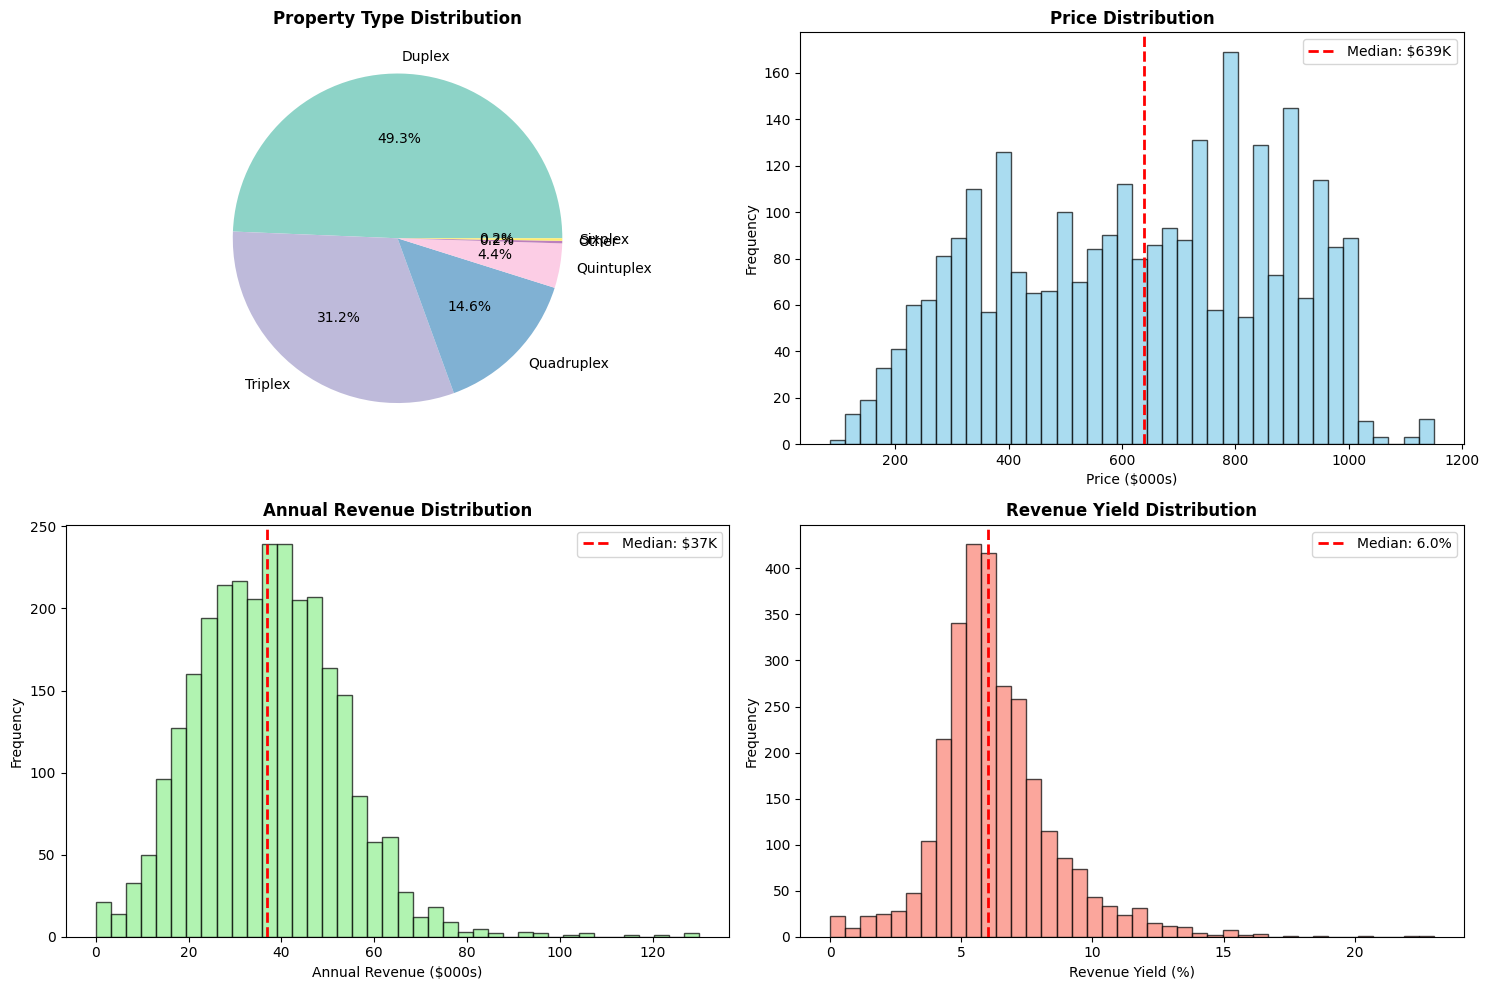

Market Statistics Summary:
  Total properties analyzed: 2,839
  Average price: $624,907
  Average revenue yield: 6.32%
  Price range: $85,000 - $1,149,950
  Yield range: 0.0% - 23.0%


In [9]:
# Market distribution overview
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Property type distribution
category_counts = data['category_clean'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(category_counts)))
axes[0,0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', colors=colors)
axes[0,0].set_title('Property Type Distribution', fontweight='bold')

# Price distribution with stats
axes[0,1].hist(data['price']/1000, bins=40, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].axvline(data['price'].median()/1000, color='red', linestyle='--', linewidth=2, label=f'Median: ${data["price"].median()/1000:.0f}K')
axes[0,1].set_title('Price Distribution', fontweight='bold')
axes[0,1].set_xlabel('Price ($000s)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Revenue distribution
axes[1,0].hist(data['gross_potential_income']/1000, bins=40, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,0].axvline(data['gross_potential_income'].median()/1000, color='red', linestyle='--', linewidth=2, 
                  label=f'Median: ${data["gross_potential_income"].median()/1000:.0f}K')
axes[1,0].set_title('Annual Revenue Distribution', fontweight='bold')
axes[1,0].set_xlabel('Annual Revenue ($000s)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Revenue yield distribution
axes[1,1].hist(data['revenue_yield'], bins=40, alpha=0.7, color='salmon', edgecolor='black')
axes[1,1].axvline(data['revenue_yield'].median(), color='red', linestyle='--', linewidth=2, 
                  label=f'Median: {data["revenue_yield"].median():.1f}%')
axes[1,1].set_title('Revenue Yield Distribution', fontweight='bold')
axes[1,1].set_xlabel('Revenue Yield (%)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Key market statistics
print("Market Statistics Summary:")
print(f"  Total properties analyzed: {len(data):,}")
print(f"  Average price: ${data['price'].mean():,.0f}")
print(f"  Average revenue yield: {data['revenue_yield'].mean():.2f}%")
print(f"  Price range: ${data['price'].min():,.0f} - ${data['price'].max():,.0f}")
print(f"  Yield range: {data['revenue_yield'].min():.1f}% - {data['revenue_yield'].max():.1f}%")

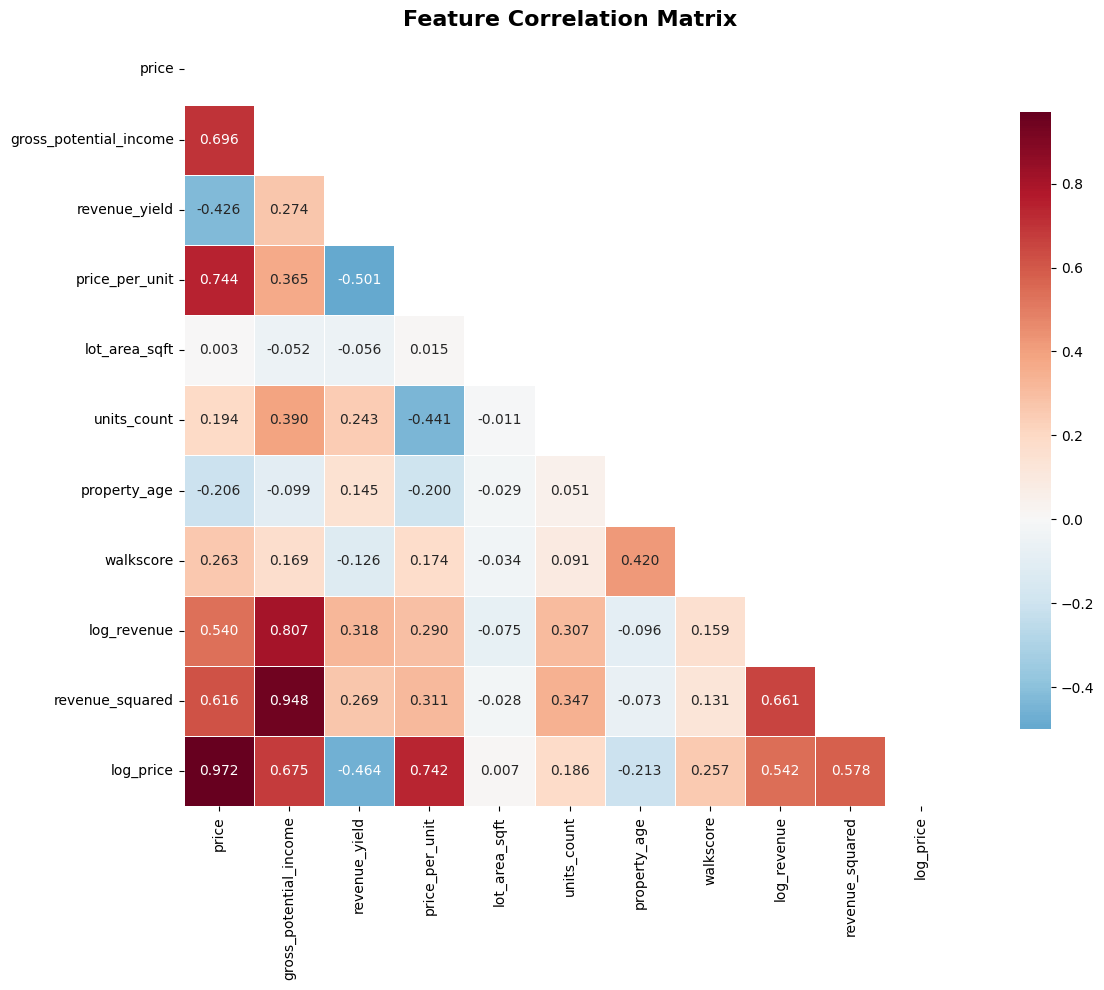

Strongest Correlations with Price:
  log_price           : 0.972 (positive)
  price_per_unit      : 0.744 (positive)
  gross_potential_income: 0.696 (positive)
  revenue_squared     : 0.616 (positive)
  log_revenue         : 0.540 (positive)
  revenue_yield       : 0.426 (negative)
  walkscore           : 0.263 (positive)

Strongest Correlations with Revenue Yield:
  price_per_unit      : 0.501 (negative)
  log_price           : 0.464 (negative)
  price               : 0.426 (negative)
  log_revenue         : 0.318 (positive)
  gross_potential_income: 0.274 (positive)


In [10]:
# Correlation analysis of key financial and property features
key_features = ['price', 'gross_potential_income', 'revenue_yield', 'price_per_unit',
                'living_area_sqft', 'lot_area_sqft', 'units_count', 'property_age', 'walkscore']

# Include transformed variables
transformed_features = ['log_revenue', 'revenue_squared', 'log_price']
all_features = key_features + transformed_features

# Select only available features
available_features = [col for col in all_features if col in data.columns and data[col].notna().sum() > 100]
corr_matrix = data[available_features].corr()

# Create correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

# Highlight strongest correlations with price
price_corr = corr_matrix['price'].abs().sort_values(ascending=False)
print("Strongest Correlations with Price:")
for feature, corr_val in price_corr.head(8).items():
    if feature != 'price':
        direction = "positive" if corr_matrix.loc['price', feature] > 0 else "negative"
        print(f"  {feature:20}: {corr_val:.3f} ({direction})")

# Revenue yield relationships
if 'revenue_yield' in corr_matrix.columns:
    yield_corr = corr_matrix['revenue_yield'].abs().sort_values(ascending=False)
    print(f"\nStrongest Correlations with Revenue Yield:")
    for feature, corr_val in yield_corr.head(6).items():
        if feature != 'revenue_yield':
            direction = "positive" if corr_matrix.loc['revenue_yield', feature] > 0 else "negative"
            print(f"  {feature:20}: {corr_val:.3f} ({direction})")

In [11]:
# Geographic distribution of properties
if 'lat' in data.columns and 'lng' in data.columns:
    # Remove properties with missing coordinates
    geo_data = data.dropna(subset=['lat', 'lng'])
    
    fig = px.scatter_mapbox(
        geo_data, 
        lat='lat', 
        lon='lng',
        color='revenue_yield',
        size='price',
        hover_data=['price', 'gross_potential_income', 'category_clean'],
        color_continuous_scale='RdYlGn',
        title='Geographic Distribution of Plex Properties (Color = Revenue Yield, Size = Price)',
        mapbox_style='open-street-map',
        zoom=7
    )
    
    fig.update_layout(height=600)
    fig.show()
else:
    print("Geographic coordinates not available for mapping")

## 5. Investment Opportunity Identification

In [12]:
# Calculate market benchmarks for investment analysis
market_benchmarks = {
    'median_yield': data['revenue_yield'].median(),
    'q75_yield': data['revenue_yield'].quantile(0.75),
    'median_price_per_unit': data['price_per_unit'].median(),
    'q25_price_per_unit': data['price_per_unit'].quantile(0.25)
}

print("Market Benchmarks:")
print(f"  Median revenue yield: {market_benchmarks['median_yield']:.2f}%")
print(f"  Top quartile yield: {market_benchmarks['q75_yield']:.2f}%")
print(f"  Median price per unit: ${market_benchmarks['median_price_per_unit']:,.0f}")

# Benchmarks by property type (key metrics only)
type_benchmarks = data.groupby('category_clean').agg({
    'revenue_yield': ['count', 'median'],
    'price_per_unit': 'median',
    'price': 'median'
}).round(2)

type_benchmarks.columns = ['Count', 'Median_Yield_%', 'Median_Price_per_Unit', 'Median_Price']
print(f"\nBenchmarks by Property Type:")
print(type_benchmarks)

Market Benchmarks:
  Median revenue yield: 6.00%
  Top quartile yield: 7.33%
  Median price per unit: $238,000

Benchmarks by Property Type:
                Count  Median_Yield_%  Median_Price_per_Unit  Median_Price
category_clean                                                            
Duplex           1389            5.78              286912.50      573825.0
Other               7            3.16              645000.00      645000.0
Quadruplex        414            6.77              170402.50      681610.0
Quintuplex        124            7.39              135500.00      677500.0
Sixplex             7            7.95              123296.17      739777.0
Triplex           885            5.87              255966.67      767900.0


In [13]:
# Enhanced discount scoring system
data['discount_score'] = 0

# Criteria 1: High revenue yield (2 points for top 25%, 1 point for above median)
data.loc[data['revenue_yield'] > market_benchmarks['q75_yield'], 'discount_score'] += 2
data.loc[(data['revenue_yield'] > market_benchmarks['median_yield']) & 
         (data['revenue_yield'] <= market_benchmarks['q75_yield']), 'discount_score'] += 1

# Criteria 2: Low price per unit (2 points for bottom 25%)
data.loc[data['price_per_unit'] < market_benchmarks['q25_price_per_unit'], 'discount_score'] += 2

# Criteria 3: Below-median price per sqft (if available)
if 'price_per_sqft' in data.columns:
    median_price_sqft = data['price_per_sqft'].median()
    data.loc[data['price_per_sqft'] < median_price_sqft, 'discount_score'] += 1

# Criteria 4: Good location (walkscore bonus)
if 'walkscore' in data.columns:
    high_walkscore = data['walkscore'].quantile(0.75)
    data.loc[data['walkscore'] > high_walkscore, 'discount_score'] += 1

# Identify investment opportunities
excellent_opportunities = data[data['discount_score'] >= 4]
good_opportunities = data[data['discount_score'] == 3]

print("Investment Opportunity Analysis:")
print(f"  Total properties: {len(data):,}")
print(f"  Excellent opportunities (score ≥4): {len(excellent_opportunities):,} ({100*len(excellent_opportunities)/len(data):.1f}%)")
print(f"  Good opportunities (score =3): {len(good_opportunities):,} ({100*len(good_opportunities)/len(data):.1f}%)")
print(f"  Combined opportunities: {len(excellent_opportunities) + len(good_opportunities):,} ({100*(len(excellent_opportunities) + len(good_opportunities))/len(data):.1f}%)")

if len(excellent_opportunities) > 0:
    print(f"\nTop 5 Investment Opportunities (Score ≥4):")
    
    # Prepare columns for display (including MLS)
    display_cols = ['price', 'gross_potential_income', 'revenue_yield', 'price_per_unit', 'category_clean', 'discount_score']
    if 'mls' in excellent_opportunities.columns:
        display_cols = ['mls'] + display_cols
    elif excellent_opportunities.index.name == 'mls':
        # Reset index to show MLS as a column
        top_opportunities = excellent_opportunities.nlargest(5, 'revenue_yield')[display_cols].copy()
        top_opportunities.insert(0, 'mls', top_opportunities.index)
        print(top_opportunities.round(2))
    else:
        top_opportunities = excellent_opportunities.nlargest(5, 'revenue_yield')[display_cols]
        print(top_opportunities.round(2))
    
    if 'mls' in excellent_opportunities.columns or excellent_opportunities.index.name == 'mls':
        print(f"\n📋 MLS Property Tracker:")
        top_5 = excellent_opportunities.nlargest(5, 'revenue_yield')
        for i, (mls_num, row) in enumerate(top_5.iterrows(), 1):
            mls_display = mls_num if excellent_opportunities.index.name == 'mls' else row['mls']
            print(f"  {i}. MLS #{mls_display}: {row['category_clean']} - {row['revenue_yield']:.1f}% yield @ ${row['price']:,.0f}")

Investment Opportunity Analysis:
  Total properties: 2,839
  Excellent opportunities (score ≥4): 579 (20.4%)
  Good opportunities (score =3): 317 (11.2%)
  Combined opportunities: 896 (31.6%)

Top 5 Investment Opportunities (Score ≥4):
               mls   price  gross_potential_income  revenue_yield  \
mls                                                                 
27913315  27913315  299900                 69000.0          23.01   
21655311  21655311  175000                 38640.0          22.08   
15660869  15660869  174000                 36000.0          20.69   
26636095  26636095  275000                 48000.0          17.45   
15599239  15599239  360000                 59832.0          16.62   

          price_per_unit category_clean  discount_score  
mls                                                      
27913315        99966.67        Triplex               5  
21655311        87500.00         Duplex               5  
15660869        43500.00     Quadruplex         

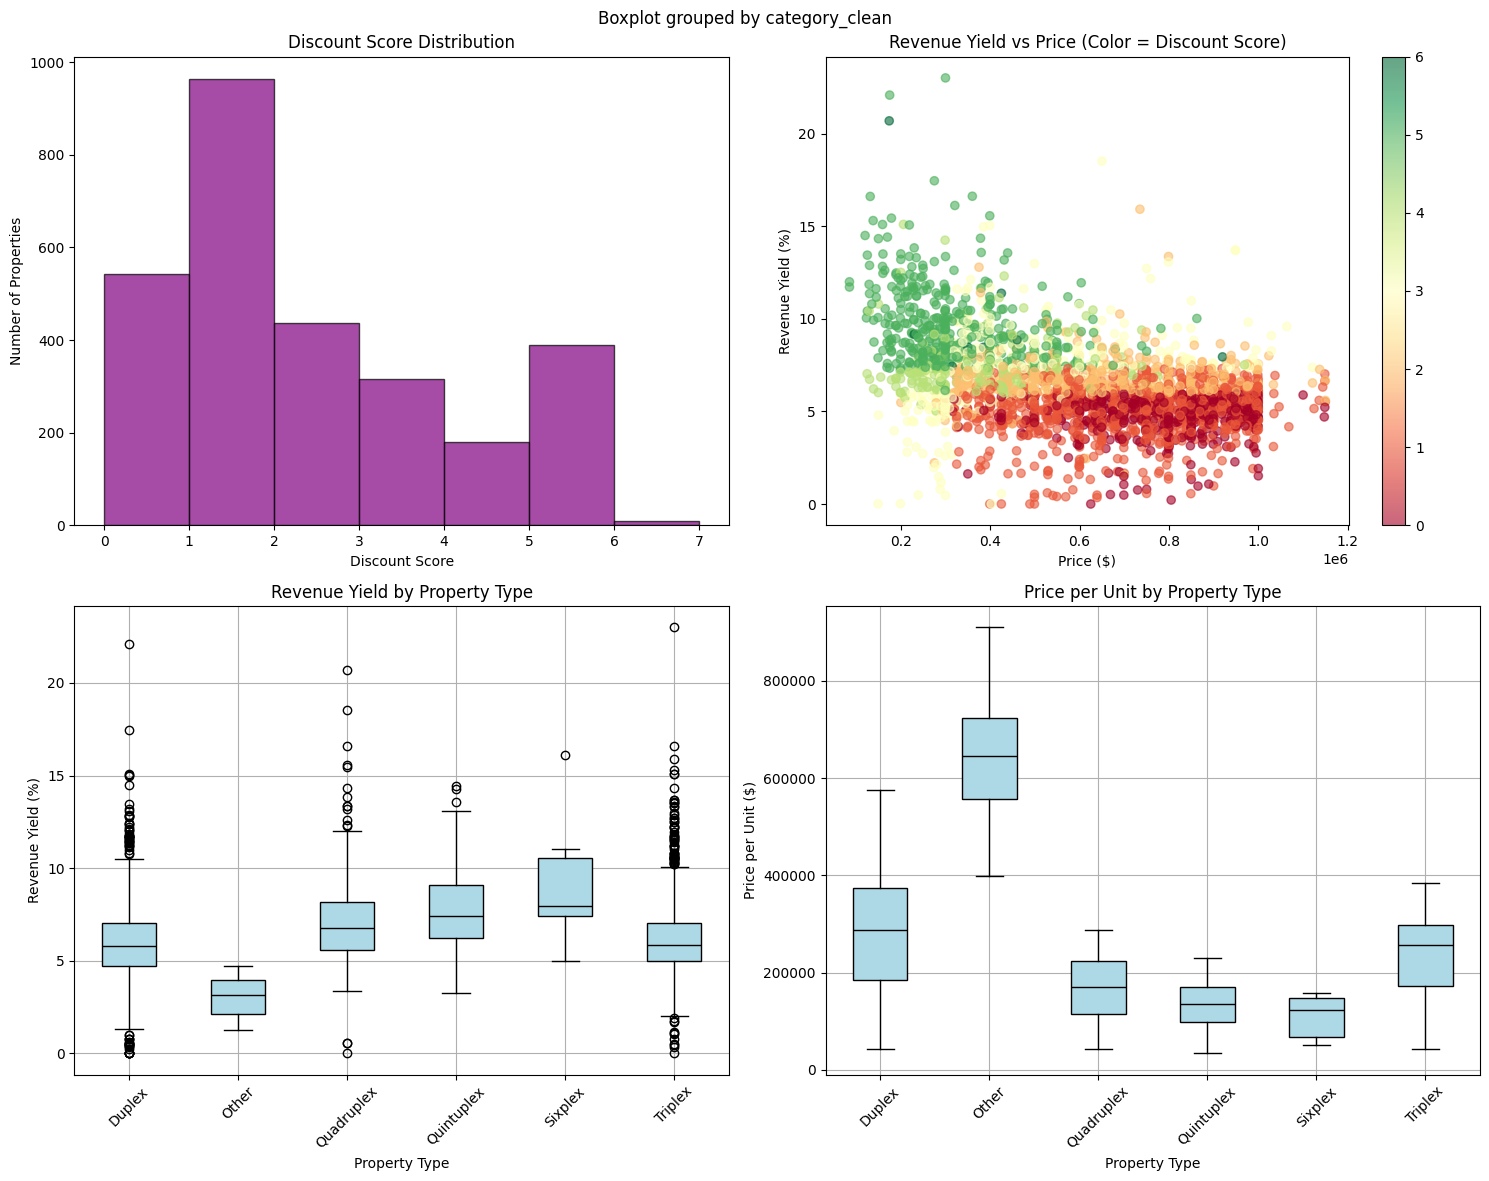

In [14]:
# Visualize discount scoring
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Discount score distribution
axes[0,0].hist(data['discount_score'], bins=range(0, int(data['discount_score'].max())+2), 
               alpha=0.7, color='purple', edgecolor='black')
axes[0,0].set_title('Discount Score Distribution')
axes[0,0].set_xlabel('Discount Score')
axes[0,0].set_ylabel('Number of Properties')

# Revenue yield vs Price scatter
scatter = axes[0,1].scatter(data['price'], data['revenue_yield'], 
                           c=data['discount_score'], cmap='RdYlGn', alpha=0.6)
axes[0,1].set_title('Revenue Yield vs Price (Color = Discount Score)')
axes[0,1].set_xlabel('Price ($)')
axes[0,1].set_ylabel('Revenue Yield (%)')
plt.colorbar(scatter, ax=axes[0,1])

# Revenue yield by property type
data.boxplot(
    column='revenue_yield',
    by='category_clean',
    ax=axes[1,0],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', edgecolor='black'),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)
axes[1,0].set_title('Revenue Yield by Property Type')
axes[1,0].set_xlabel('Property Type')
axes[1,0].set_ylabel('Revenue Yield (%)')
axes[1,0].tick_params(axis='x', rotation=45)

# Price per unit by property type
data.boxplot(
    column='price_per_unit',
    by='category_clean',
    ax=axes[1,1],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', edgecolor='black'),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)
axes[1,1].set_title('Price per Unit by Property Type')
axes[1,1].set_xlabel('Property Type')
axes[1,1].set_ylabel('Price per Unit ($)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Predictive Modeling & Validation

In [15]:
# Comprehensive regression analysis comparing transformations
print("Predictive Model Comparison: Linear vs Transformed Variables")
print("=" * 60)

# Prepare clean data for modeling
modeling_data = data.dropna(subset=['price', 'gross_potential_income', 'log_revenue'])

# Model 1: Simple linear (baseline)
X_linear = modeling_data[['gross_potential_income']]
y = modeling_data['price']

# Model 2: Log-transformed revenue
X_log = modeling_data[['log_revenue']]

# Model 3: Polynomial (revenue + revenue²)
X_poly = modeling_data[['gross_potential_income', 'revenue_squared']]

# Split data consistently
X_train_lin, X_test_lin, y_train, y_test = train_test_split(X_linear, y, test_size=0.2, random_state=42)
X_train_log = modeling_data.loc[X_train_lin.index, ['log_revenue']]
X_test_log = modeling_data.loc[X_test_lin.index, ['log_revenue']]
X_train_poly = modeling_data.loc[X_train_lin.index, ['gross_potential_income', 'revenue_squared']]
X_test_poly = modeling_data.loc[X_test_lin.index, ['gross_potential_income', 'revenue_squared']]

# Train models
models = {}
models['Linear'] = LinearRegression().fit(X_train_lin, y_train)
models['Log-Revenue'] = LinearRegression().fit(X_train_log, y_train)
models['Polynomial'] = LinearRegression().fit(X_train_poly, y_train)

# Evaluate models
results = {}
for name, model in models.items():
    if name == 'Linear':
        pred = model.predict(X_test_lin)
    elif name == 'Log-Revenue':
        pred = model.predict(X_test_log)
    else:  # Polynomial
        pred = model.predict(X_test_poly)
    
    results[name] = {
        'R²': r2_score(y_test, pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
        'MAE': mean_absolute_error(y_test, pred)
    }

# Display results
print("Model Performance Comparison:")
for model_name, metrics in results.items():
    print(f"\n{model_name} Model:")
    print(f"  R² Score: {metrics['R²']:.4f}")
    print(f"  RMSE: ${metrics['RMSE']:,.0f}")
    print(f"  MAE: ${metrics['MAE']:,.0f}")

# Store best performing model for later use
best_model_name = max(results.keys(), key=lambda k: results[k]['R²'])
print(f"\nBest performing model: {best_model_name} (R² = {results[best_model_name]['R²']:.4f})")

Predictive Model Comparison: Linear vs Transformed Variables
Model Performance Comparison:

Linear Model:
  R² Score: 0.4128
  RMSE: $179,484
  MAE: $143,778

Log-Revenue Model:
  R² Score: 0.2881
  RMSE: $197,627
  MAE: $165,116

Polynomial Model:
  R² Score: 0.4275
  RMSE: $177,219
  MAE: $140,563

Best performing model: Polynomial (R² = 0.4275)


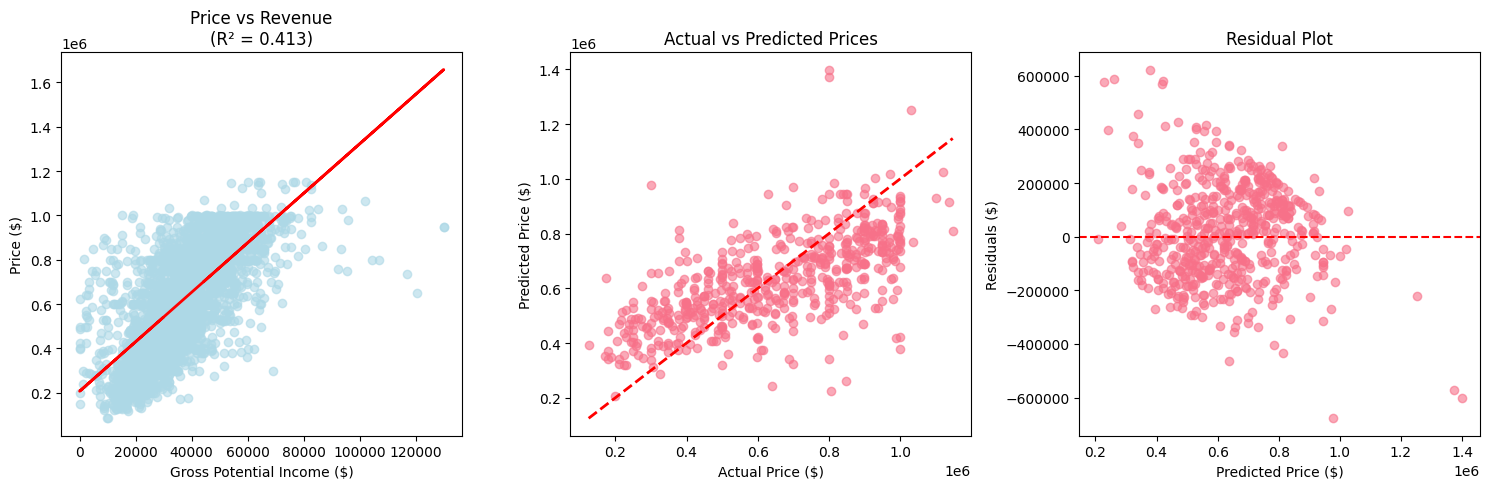

In [16]:
# Visualize simple regression
plt.figure(figsize=(15, 5))

# Scatter plot with regression line
plt.subplot(1, 3, 1)
plt.scatter(modeling_data['gross_potential_income'], modeling_data['price'], 
           alpha=0.6, color='lightblue')
plt.plot(modeling_data['gross_potential_income'], 
         models['Linear'].predict(modeling_data[['gross_potential_income']]), 
         color='red', linewidth=2)
plt.xlabel('Gross Potential Income ($)')
plt.ylabel('Price ($)')
plt.title(f'Price vs Revenue\n(R² = {results["Linear"]["R²"]:.3f})')

# Actual vs Predicted
plt.subplot(1, 3, 2)
y_pred_simple = models['Linear'].predict(X_test_lin)
plt.scatter(y_test, y_pred_simple, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted Prices')

# Residuals plot
plt.subplot(1, 3, 3)
residuals = y_test - y_pred_simple
plt.scatter(y_pred_simple, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

### 6.1 Multi-Feature Enhanced Models

In [17]:
# Enhanced multi-feature model with best transformations
feature_columns = ['gross_potential_income', 'log_revenue', 'units_count', 'living_area_sqft', 
                  'lot_area_sqft', 'property_age', 'walkscore']

# Select available features with sufficient data
available_features = [col for col in feature_columns if col in data.columns and data[col].notna().sum() > len(data)*0.7]
categorical_features = ['category_clean'] if 'category_clean' in data.columns else []

# Preserve MLS numbers in enhanced dataset
essential_cols = ['price'] + available_features + categorical_features
if 'mls' in data.columns:
    essential_cols = ['mls'] + essential_cols
    
print(f"Enhanced Model Features:")
print(f"  Numerical features: {available_features}")
print(f"  Categorical features: {categorical_features}")
print(f"  MLS preservation: {'✓ Included' if 'mls' in essential_cols else '✗ Not found'}")

# Create enhanced dataset with MLS preservation
enhanced_data = data[essential_cols].copy()
enhanced_data = enhanced_data.dropna()

# If MLS was in the index, preserve it
if data.index.name == 'mls' and 'mls' not in enhanced_data.columns:
    enhanced_data['mls'] = enhanced_data.index

print(f"  Enhanced dataset: {enhanced_data.shape[0]:,} properties ({100*enhanced_data.shape[0]/len(data):.1f}% of total)")
print(f"  MLS numbers preserved: {enhanced_data['mls'].nunique() if 'mls' in enhanced_data.columns else 'Index-based'} unique properties")

Enhanced Model Features:
  Numerical features: ['gross_potential_income', 'log_revenue', 'units_count', 'lot_area_sqft', 'property_age', 'walkscore']
  Categorical features: ['category_clean']
  MLS preservation: ✗ Not found
  Enhanced dataset: 2,442 properties (86.0% of total)
  MLS numbers preserved: 2442 unique properties


In [18]:
# Prepare features for enhanced model
X_enhanced = enhanced_data[available_features].copy()

# Add categorical features using one-hot encoding
if categorical_features:
    for cat_col in categorical_features:
        # Create dummy variables
        dummies = pd.get_dummies(enhanced_data[cat_col], prefix=cat_col)
        X_enhanced = pd.concat([X_enhanced, dummies], axis=1)

y_enhanced = enhanced_data['price']

print(f"Enhanced feature matrix shape: {X_enhanced.shape}")
print(f"Enhanced features: {list(X_enhanced.columns)}")

Enhanced feature matrix shape: (2442, 12)
Enhanced features: ['gross_potential_income', 'log_revenue', 'units_count', 'lot_area_sqft', 'property_age', 'walkscore', 'category_clean_Duplex', 'category_clean_Other', 'category_clean_Quadruplex', 'category_clean_Quintuplex', 'category_clean_Sixplex', 'category_clean_Triplex']


In [19]:
# Split and train enhanced model
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

# Fit enhanced linear regression model
enhanced_model = LinearRegression()
enhanced_model.fit(X_train_enh, y_train_enh)

# Predictions
y_pred_enhanced = enhanced_model.predict(X_test_enh)

# Model evaluation
r2_enhanced = r2_score(y_test_enh, y_pred_enhanced)
rmse_enhanced = np.sqrt(mean_squared_error(y_test_enh, y_pred_enhanced))
mae_enhanced = mean_absolute_error(y_test_enh, y_pred_enhanced)

print(f"Enhanced Model Performance:")
print(f"R² Score: {r2_enhanced:.4f}")
print(f"RMSE: ${rmse_enhanced:,.0f}")
print(f"MAE: ${mae_enhanced:,.0f}")

Enhanced Model Performance:
R² Score: 0.5315
RMSE: $169,559
MAE: $133,599


Feature Importance (by absolute coefficient):
                      feature   coefficient  abs_coefficient
1                 log_revenue -52778.117155     52778.117155
2                 units_count -39113.779220     39113.779220
6       category_clean_Duplex -34288.471926     34288.471926
11     category_clean_Triplex  24579.079553     24579.079553
7        category_clean_Other  22106.531889     22106.531889
10     category_clean_Sixplex  -6964.428746      6964.428746
9   category_clean_Quintuplex  -2863.190360      2863.190360
8   category_clean_Quadruplex  -2569.520409      2569.520409
5                   walkscore   2362.581025      2362.581025
4                property_age  -1713.168530      1713.168530


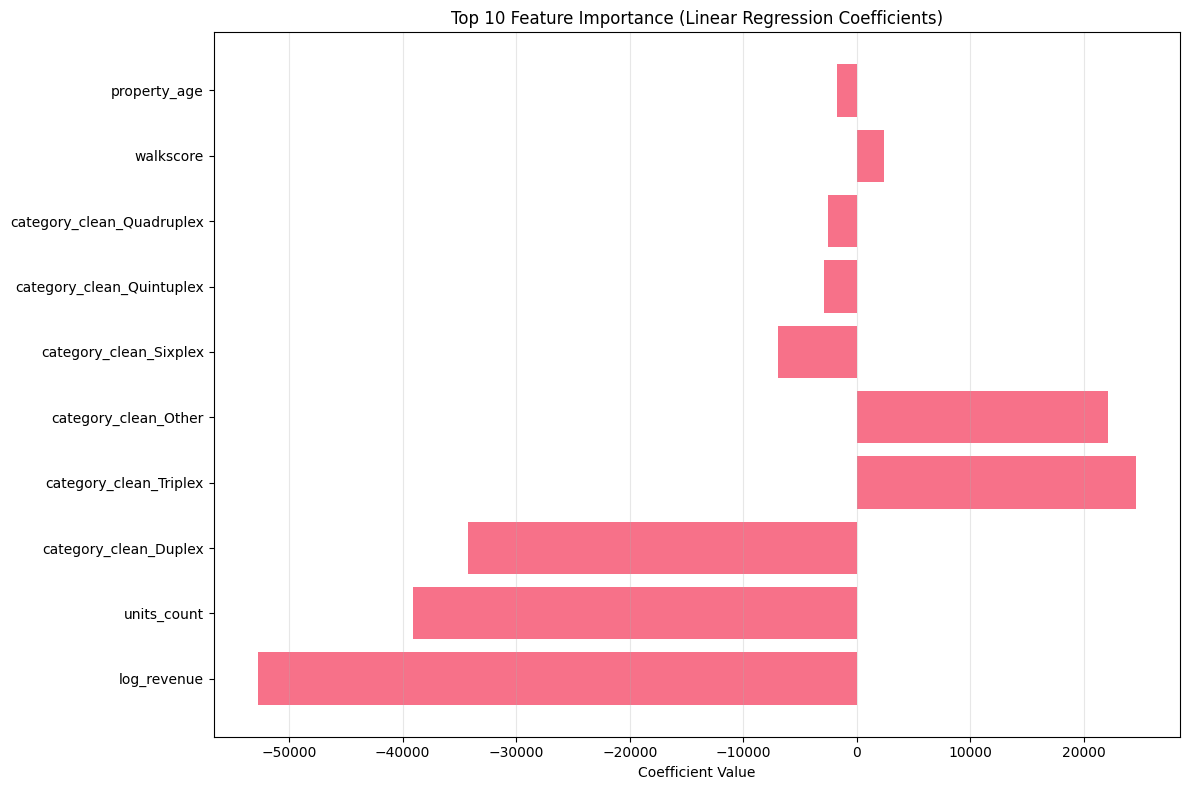

In [20]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_enhanced.columns,
    'coefficient': enhanced_model.coef_,
    'abs_coefficient': np.abs(enhanced_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("Feature Importance (by absolute coefficient):")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Importance (Linear Regression Coefficients)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# Try Random Forest for comparison
print("Training Random Forest model for comparison...")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_enh, y_train_enh)

# Predictions
y_pred_rf = rf_model.predict(X_test_enh)

# Model evaluation
r2_rf = r2_score(y_test_enh, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_enh, y_pred_rf))
mae_rf = mean_absolute_error(y_test_enh, y_pred_rf)

print(f"Random Forest Model Performance:")
print(f"R² Score: {r2_rf:.4f}")
print(f"RMSE: ${rmse_rf:,.0f}")
print(f"MAE: ${mae_rf:,.0f}")

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'feature': X_enhanced.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_importance.head(10))

Training Random Forest model for comparison...
Random Forest Model Performance:
R² Score: 0.6663
RMSE: $143,106
MAE: $110,100

Random Forest Feature Importance:
                      feature  importance
1                 log_revenue    0.344443
0      gross_potential_income    0.305148
3               lot_area_sqft    0.113322
4                property_age    0.107700
5                   walkscore    0.089450
2                 units_count    0.019696
11     category_clean_Triplex    0.009564
6       category_clean_Duplex    0.005594
8   category_clean_Quadruplex    0.002874
9   category_clean_Quintuplex    0.001836
Random Forest Model Performance:
R² Score: 0.6663
RMSE: $143,106
MAE: $110,100

Random Forest Feature Importance:
                      feature  importance
1                 log_revenue    0.344443
0      gross_potential_income    0.305148
3               lot_area_sqft    0.113322
4                property_age    0.107700
5                   walkscore    0.089450
2          

## 7. Model Evaluation and Comparison

Model Comparison:
                          Model  R² Score         RMSE          MAE
0  Simple Linear (Revenue only)    0.4128  179483.6494  143778.3166
1               Enhanced Linear    0.5315  169558.9550  133598.8128
2                 Random Forest    0.6663  143106.1698  110099.6117


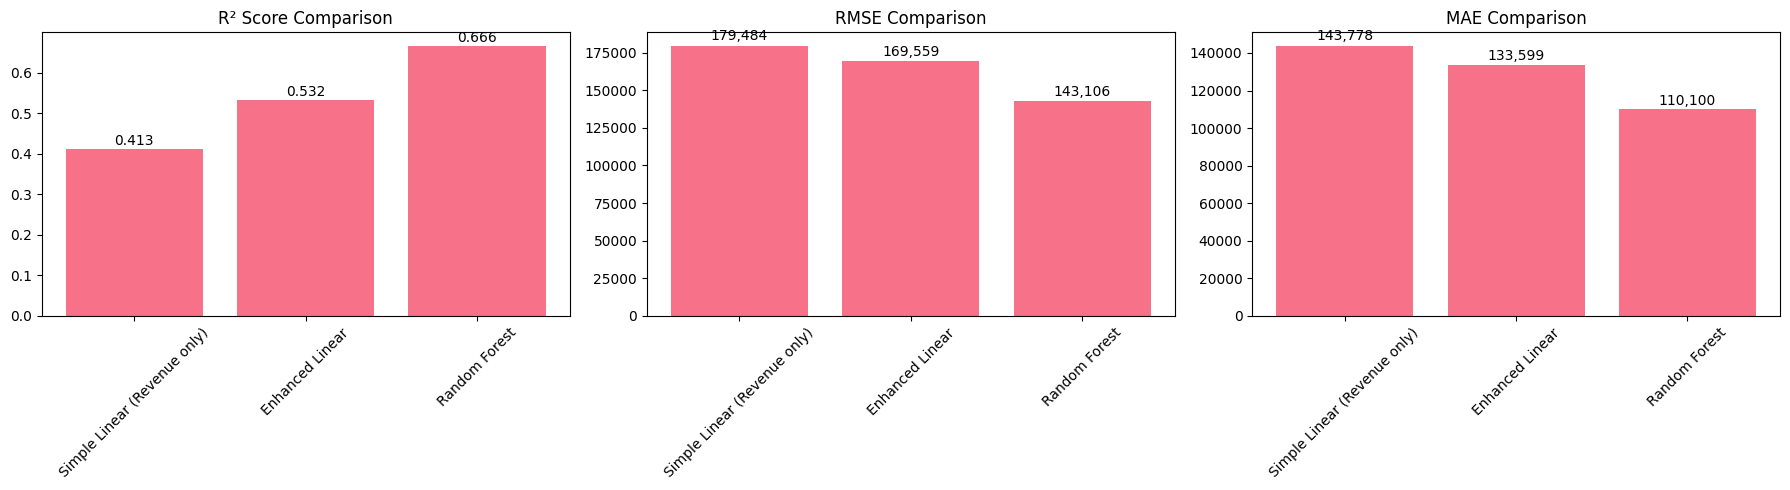

In [22]:
# Compare all models
# Gather metrics for all models
r2_simple = results['Linear']['R²']
rmse_simple = results['Linear']['RMSE']
mae_simple = results['Linear']['MAE']

model_comparison = pd.DataFrame({
    'Model': ['Simple Linear (Revenue only)', 'Enhanced Linear', 'Random Forest'],
    'R² Score': [r2_simple, r2_enhanced, r2_rf],
    'RMSE': [rmse_simple, rmse_enhanced, rmse_rf],
    'MAE': [mae_simple, mae_enhanced, mae_rf]
})

print("Model Comparison:")
print(model_comparison.round(4))

# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['R² Score', 'RMSE', 'MAE']
for i, metric in enumerate(metrics):
    axes[i].bar(model_comparison['Model'], model_comparison[metric])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for j, v in enumerate(model_comparison[metric]):
        if metric == 'R² Score':
            axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center')
        else:
            axes[i].text(j, v + v*0.02, f'{v:,.0f}', ha='center')

plt.tight_layout()
plt.show()

Best performing model: Random Forest


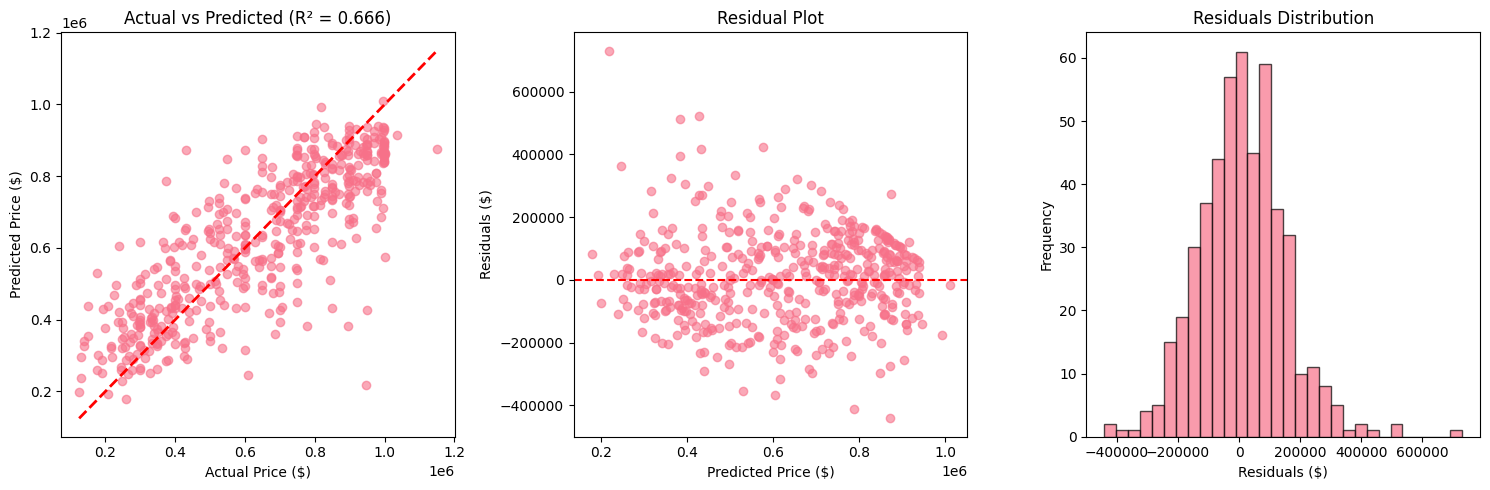

In [23]:
# Residual analysis for best model
best_model_name = model_comparison.loc[model_comparison['R² Score'].idxmax(), 'Model']
print(f"Best performing model: {best_model_name}")

# Use Random Forest predictions for analysis (assuming it's the best)
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test_enh, y_pred_rf, alpha=0.6)
plt.plot([y_test_enh.min(), y_test_enh.max()], [y_test_enh.min(), y_test_enh.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'Actual vs Predicted (R² = {r2_rf:.3f})')

# Residuals
plt.subplot(1, 3, 2)
residuals_rf = y_test_enh - y_pred_rf
plt.scatter(y_pred_rf, residuals_rf, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot')

# Residuals histogram
plt.subplot(1, 3, 3)
plt.hist(residuals_rf, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals ($)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')

plt.tight_layout()
plt.show()

## 9. Executive Dashboard & Investment Opportunities

## 7. Advanced Statistical Modeling

Stepwise regression with AIC/BIC selection for optimal feature identification and model validation.

In [24]:
# Prepare standardized data for stepwise regression with MLS preservation
print("Preparing stepwise regression data with MLS preservation...")

# Prepare stepwise data while maintaining MLS connection
data_stepwise, scaler_stepwise = prepare_plex_data(
    df=df_with_mls,  # Use the MLS-indexed dataframe
    target_year=config['target_year'],
    assessment_growth_rate=config['assessment_growth_rate'], 
    standardize=True,  # Standardize for regression
    drop_original_geo=True  # Clean modeling dataset
)

# Add transformed variables
data_stepwise['log_revenue'] = np.log(data_stepwise['gross_potential_income'] + 1)
data_stepwise['revenue_squared'] = data_stepwise['gross_potential_income'] ** 2

# Preserve MLS numbers in stepwise data
if data_stepwise.index.name != 'mls' and 'mls' not in data_stepwise.columns:
    # Restore MLS from original alignment
    data_stepwise['mls'] = data_stepwise.index
    
# Prepare modeling variables
num_vars, cat_vars, interaction_terms = prepare_modeling_variables(data_stepwise)
formula_scope = create_formula_scope('price', num_vars, cat_vars, interaction_terms)

print(f"Stepwise modeling dataset: {data_stepwise.shape[0]:,} properties")
print(f"Variables prepared: {len(num_vars)} numerical, {len(cat_vars)} categorical")
print(f"Interaction terms: {len(interaction_terms)}")
print(f"MLS preservation: {'✓ Preserved' if 'mls' in data_stepwise.columns or data_stepwise.index.name == 'mls' else '✗ Missing'}")

# Initial model formula (include transformed variables)
enhanced_num_vars = [v for v in num_vars if v in data_stepwise.columns] + ['log_revenue']
initial_formula = "price ~ " + " + ".join(enhanced_num_vars[:8] + ['revenue_squared'])  # Include revenue_squared
print(f"Initial model: {initial_formula}")

Preparing stepwise regression data with MLS preservation...
Adjusting assessment values to 2025 using 5.7% annual growth...
Standardizing building style labels...
Creating geographic features...
Encoding building styles...
Creating financial and property features...
New features created: ['revenue_yield', 'price_per_unit', 'price_per_sqft', 'income_per_unit', 'property_age', 'distance_from_mtl', 'Detached', 'Row', 'Semi_detached']
Standardizing numerical features...
Standardized columns: ['price', 'year_built', 'walkscore', 'lot_area_sqft', 'units_count', 'gross_potential_income', 'assessment_total_adj', 'distance_from_mtl', 'revenue_yield', 'price_per_unit', 'price_per_sqft', 'income_per_unit', 'property_age']
Stepwise modeling dataset: 2,839 properties
Variables prepared: 14 numerical, 3 categorical
Interaction terms: 2
MLS preservation: ✓ Preserved
Initial model: price ~ year_built + walkscore + lot_area_sqft + units_count + gross_potential_income + assessment_total_adj + distance_f

In [25]:
# AIC-based stepwise variable selection
print("Running AIC-based stepwise selection...")

res_aic = step_criterion(
    data_stepwise,
    initial=initial_formula,
    scope=formula_scope,
    criterion='aic'
)

print("AIC Selection Summary:")
print(f"  Final model variables: {len(res_aic.model.params)}")
print(f"  R-squared: {res_aic.model.rsquared:.4f}")
print(f"  Adjusted R-squared: {res_aic.model.rsquared_adj:.4f}")
print(f"  AIC: {res_aic.model.aic:.2f}")

# Show selection steps (last 5 only)
if hasattr(res_aic, 'anova') and len(res_aic.anova) > 5:
    print(f"\nFinal selection steps:")
    print(res_aic.anova.tail())
else:
    print(f"\nSelection steps:")
    print(res_aic.anova)

Running AIC-based stepwise selection...
Start:  AIC=320.471
price ~ 1 + year_built + walkscore + lot_area_sqft + units_count + gross_potential_income + assessment_total_adj + distance_from_mtl + revenue_yield + revenue_squared 

Op                               Term  Score (AIC)         AIC
 +                     price_per_unit  -859.956490 -859.956490
 +                        log_revenue  -245.499354 -245.499354
 +                           Detached   259.772224  259.772224
 +                      Semi_detached   289.535181  289.535181
 +                                Row   312.966925  312.966925
 + units_count:gross_potential_income   316.627690  316.627690
 +                    income_per_unit   320.412126  320.412126
 -                          walkscore   320.620616  320.620616
 +                     price_per_sqft   321.035964  321.035964
 -                  distance_from_mtl   321.162339  321.162339
 +          units_count:revenue_yield   322.468764  322.468764
 +             

In [26]:
# BIC-based stepwise selection (more parsimonious)
print("Running BIC-based stepwise selection...")

res_bic = step_criterion(
    data_stepwise,
    initial=initial_formula,
    scope=formula_scope,
    criterion='bic'
)

# Compare AIC vs BIC models
print("Model Comparison: AIC vs BIC Selection")
print("=" * 50)
comparison_data = {
    'AIC Model': [res_aic.model.rsquared, res_aic.model.rsquared_adj, len(res_aic.model.params), res_aic.model.aic],
    'BIC Model': [res_bic.model.rsquared, res_bic.model.rsquared_adj, len(res_bic.model.params), res_bic.model.bic]
}

comparison_df = pd.DataFrame(comparison_data, 
                           index=['R-squared', 'Adj R-squared', 'Variables', 'Criterion Value'])
print(comparison_df.round(4))

# Select best model (BIC for parsimony)
best_model = res_bic.model
print(f"\nSelected Model: BIC (more parsimonious)")
print(f"  Variables: {len(best_model.params)}")
print(f"  R²: {best_model.rsquared:.4f}")
print(f"  Adj R²: {best_model.rsquared_adj:.4f}")

# Key coefficients
print(f"\nTop 5 Most Significant Variables:")
significant_vars = best_model.pvalues.sort_values().head(6)[1:]  # Exclude intercept
for var, p_val in significant_vars.items():
    coef = best_model.params[var]
    print(f"  {var:20}: coef={coef:7.4f}, p={p_val:.4f}")

Running BIC-based stepwise selection...
Start:  AIC=378.245
price ~ 1 + year_built + walkscore + lot_area_sqft + units_count + gross_potential_income + assessment_total_adj + distance_from_mtl + revenue_yield + revenue_squared 

Op                               Term         BIC         AIC
 +                     price_per_unit -796.405380 -796.405380
 +                        log_revenue -184.050094 -184.050094
 +                           Detached  323.323334  323.323334
 +                      Semi_detached  353.086291  353.086291
 -                          walkscore  372.781435  372.781435
 -                  distance_from_mtl  373.158701  373.158701
 +                                Row  376.518035  376.518035
 -                        units_count  379.139203  379.139203
 + units_count:gross_potential_income  380.178799  380.178799
 -                      lot_area_sqft  382.008180  382.008180
 +                    income_per_unit  383.963236  383.963236
 +                     pric

### 7.1 Model Performance & Diagnostics

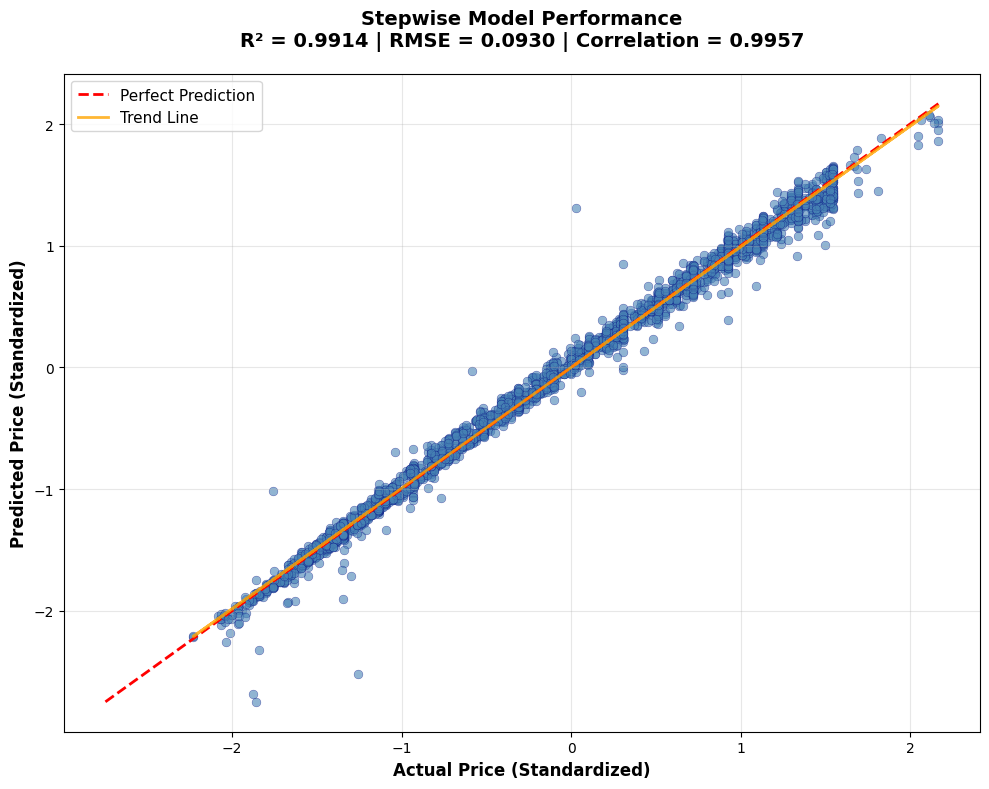

Model Performance Summary:
  R² = 0.9914
  Adjusted R² = 0.9914
  RMSE = 0.0930 (standardized units)
  MAE = 0.0608 (standardized units)
  Variables selected: 12


In [27]:
# Model performance visualization
y_actual = best_model.model.endog
y_predicted = best_model.fittedvalues
residuals = best_model.resid

# Calculate key metrics
r_squared = best_model.rsquared
adj_r_squared = best_model.rsquared_adj
rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
mae = mean_absolute_error(y_actual, y_predicted)
correlation = np.corrcoef(y_actual, y_predicted)[0, 1]

# Actual vs Predicted visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(y_actual, y_predicted, alpha=0.6, s=40, color='steelblue', edgecolors='navy', linewidth=0.3)

# Perfect prediction line
min_val = min(min(y_actual), min(y_predicted))
max_val = max(max(y_actual), max(y_predicted))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Trend line
z = np.polyfit(y_actual, y_predicted, 1)
p = np.poly1d(z)
ax.plot(y_actual, p(y_actual), 'orange', linewidth=2, alpha=0.8, label=f'Trend Line')

ax.set_xlabel('Actual Price (Standardized)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Price (Standardized)', fontsize=12, fontweight='bold')
ax.set_title(f'Stepwise Model Performance\nR² = {r_squared:.4f} | RMSE = {rmse:.4f} | Correlation = {correlation:.4f}', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print(f"Model Performance Summary:")
print(f"  R² = {r_squared:.4f}")
print(f"  Adjusted R² = {adj_r_squared:.4f}")
print(f"  RMSE = {rmse:.4f} (standardized units)")
print(f"  MAE = {mae:.4f} (standardized units)")
print(f"  Variables selected: {len(best_model.params)}")

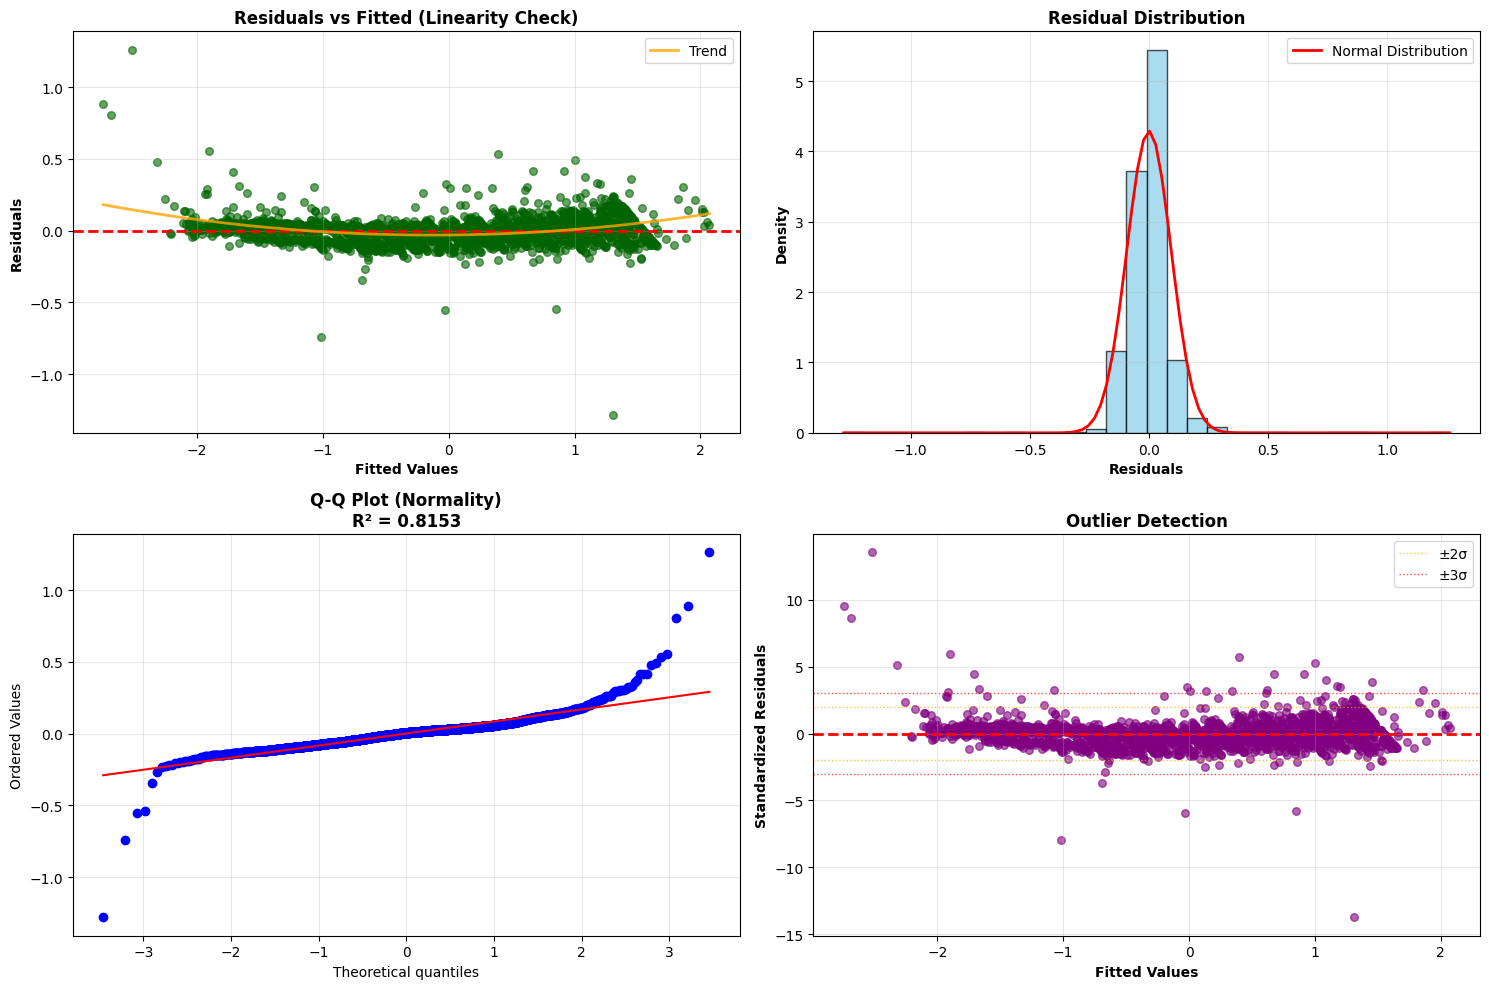

Diagnostic Summary:
  Residual mean: -0.000000 (should be ≈0)
  Residual std: 0.0930
  Normality (Q-Q R²): 0.8153 (higher is better)
  Outliers (>2σ): 73 (2.9%)
  Severe outliers (>3σ): 29 (1.1%)


In [28]:
# Essential residual diagnostics
standardized_residuals = best_model.resid_pearson

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Residuals vs Fitted (linearity check)
axes[0, 0].scatter(y_predicted, residuals, alpha=0.6, s=30, color='darkgreen')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)

# Add smooth line to detect patterns
z_res = np.polyfit(y_predicted, residuals, 2)  # Polynomial fit
p_res = np.poly1d(z_res)
sorted_pred = np.sort(y_predicted)
axes[0, 0].plot(sorted_pred, p_res(sorted_pred), 'orange', linewidth=2, alpha=0.8, label='Trend')
axes[0, 0].legend()

axes[0, 0].set_xlabel('Fitted Values', fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontweight='bold')
axes[0, 0].set_title('Residuals vs Fitted (Linearity Check)', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram of residuals (normality check)
axes[0, 1].hist(residuals, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
mu, sigma = np.mean(residuals), np.std(residuals)
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
y_norm = ((1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_norm - mu) / sigma) ** 2))
axes[0, 1].plot(x_norm, y_norm, 'red', linewidth=2, label='Normal Distribution')
axes[0, 1].set_xlabel('Residuals', fontweight='bold')
axes[0, 1].set_ylabel('Density', fontweight='bold')
axes[0, 1].set_title('Residual Distribution', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot (normality check)
(osm, osr), (slope, intercept, r_qq) = stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title(f'Q-Q Plot (Normality)\nR² = {r_qq**2:.4f}', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Standardized residuals (outlier detection)
axes[1, 1].scatter(y_predicted, standardized_residuals, alpha=0.6, s=30, color='purple')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axhline(y=2, color='orange', linestyle=':', linewidth=1, alpha=0.7, label='±2σ')
axes[1, 1].axhline(y=-2, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 1].axhline(y=3, color='red', linestyle=':', linewidth=1, alpha=0.7, label='±3σ')
axes[1, 1].axhline(y=-3, color='red', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 1].set_xlabel('Fitted Values', fontweight='bold')
axes[1, 1].set_ylabel('Standardized Residuals', fontweight='bold')
axes[1, 1].set_title('Outlier Detection', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key diagnostic statistics
outliers_2sigma = np.sum(np.abs(standardized_residuals) > 2)
outliers_3sigma = np.sum(np.abs(standardized_residuals) > 3)

print(f"Diagnostic Summary:")
print(f"  Residual mean: {np.mean(residuals):.6f} (should be ≈0)")
print(f"  Residual std: {np.std(residuals):.4f}")
print(f"  Normality (Q-Q R²): {r_qq**2:.4f} (higher is better)")
print(f"  Outliers (>2σ): {outliers_2sigma} ({100*outliers_2sigma/len(residuals):.1f}%)")
print(f"  Severe outliers (>3σ): {outliers_3sigma} ({100*outliers_3sigma/len(residuals):.1f}%)")

In [29]:
# Model validation summary
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# Key statistical tests
jb_stat, jb_p = jarque_bera(residuals)
bp_lm, bp_p, bp_f, bp_fp = het_breuschpagan(residuals, best_model.model.exog)
dw_stat = durbin_watson(residuals)

print("Model Validation Tests:")
print("=" * 40)
print(f"Linearity: {'✓ Good' if abs(np.polyfit(y_predicted, residuals, 1)[0]) < 0.1 else '⚠ Check patterns'}")
print(f"Independence (Durbin-Watson): {dw_stat:.3f} {'✓ Good' if 1.5 <= dw_stat <= 2.5 else '⚠ Potential autocorrelation'}")
print(f"Homoscedasticity (BP test): {'✓ Good' if bp_p > 0.05 else '⚠ Heteroscedasticity detected'} (p={bp_p:.4f})")
print(f"Normality (Jarque-Bera): {'✓ Good' if jb_p > 0.05 else '⚠ Non-normal residuals'} (p={jb_p:.4f})")

print(f"\nModel Quality Assessment:")
if r_squared > 0.8:
    quality = "Excellent"
elif r_squared > 0.6:
    quality = "Good"
elif r_squared > 0.4:
    quality = "Moderate"
else:
    quality = "Poor"

print(f"  Overall model quality: {quality} (R² = {r_squared:.4f})")
print(f"  Prediction accuracy: {'High' if rmse < 1.0 else 'Moderate' if rmse < 2.0 else 'Low'} (RMSE = {rmse:.4f})")
print(f"  Model complexity: {'Parsimonious' if len(best_model.params) < 15 else 'Complex'} ({len(best_model.params)} variables)")

Model Validation Tests:
Linearity: ✓ Good
Independence (Durbin-Watson): 2.007 ✓ Good
Homoscedasticity (BP test): ⚠ Heteroscedasticity detected (p=0.0000)
Normality (Jarque-Bera): ⚠ Non-normal residuals (p=0.0000)

Model Quality Assessment:
  Overall model quality: Excellent (R² = 0.9914)
  Prediction accuracy: High (RMSE = 0.0930)
  Model complexity: Parsimonious (12 variables)


In [35]:
# Advanced Outlier Detection & Property Investigation
print("🔍 Advanced Outlier Detection Analysis")
print("=" * 60)

# Ensure we have the modeling data with residuals
if 'enhanced_model' in locals() and 'X_train_enh' in locals() and 'y_train_enh' in locals():
    
    from scipy import stats
    import numpy as np
    
    # Use the training data that the model was actually fitted on
    X_analysis = X_train_enh.copy()
    y_analysis = y_train_enh.copy()
    
    # Get predictions and residuals for outlier detection
    y_pred = enhanced_model.predict(X_analysis)
    residuals = y_analysis - y_pred
    
    # Create comprehensive outlier detection dataframe
    outlier_df = pd.DataFrame(index=X_analysis.index)
    outlier_df['actual_price'] = y_analysis
    outlier_df['predicted_price'] = y_pred
    outlier_df['residuals'] = residuals
    
    # 1. Cook's Distance
    print("📊 Computing Cook's Distance...")
    from sklearn.linear_model import LinearRegression
    
    # Standardized residuals
    mse = np.mean(residuals**2)
    standardized_residuals = residuals / np.sqrt(mse)
    outlier_df['standardized_residuals'] = standardized_residuals
    
    # Leverage (hat values) - use the actual feature matrix from training
    X_numeric = X_analysis.select_dtypes(include=[np.number]).astype(np.float64)
    X_with_intercept = np.column_stack([np.ones(len(X_numeric)), X_numeric])
    
    try:
        XtX_inv = np.linalg.inv(X_with_intercept.T @ X_with_intercept)
        hat_matrix = X_with_intercept @ XtX_inv @ X_with_intercept.T
        leverage = np.diag(hat_matrix)
    except np.linalg.LinAlgError:
        # If matrix is singular, use pseudoinverse
        XtX_pinv = np.linalg.pinv(X_with_intercept.T @ X_with_intercept)
        hat_matrix = X_with_intercept @ XtX_pinv @ X_with_intercept.T
        leverage = np.diag(hat_matrix)
    
    outlier_df['leverage'] = leverage
    
    # Cook's Distance formula: (standardized_residuals^2 * leverage) / (p * (1-leverage))
    p = X_analysis.shape[1]  # number of features
    cooks_d = (standardized_residuals**2 * leverage) / (p * (1 - leverage))
    outlier_df['cooks_distance'] = cooks_d
    
    # 2. DFFITS (Difference in Fits)
    dffits = standardized_residuals * np.sqrt(leverage / (1 - leverage))
    outlier_df['dffits'] = dffits
    
    # 3. Studentized Residuals
    studentized_residuals = standardized_residuals / np.sqrt(1 - leverage)
    outlier_df['studentized_residuals'] = studentized_residuals
    
    # 4. Z-score of residuals
    z_scores = np.abs(stats.zscore(residuals))
    outlier_df['z_score'] = z_scores
    
    # 5. Modified Z-score (using median)
    median_residual = np.median(residuals)
    mad = np.median(np.abs(residuals - median_residual))
    modified_z_scores = 0.6745 * (residuals - median_residual) / mad
    outlier_df['modified_z_score'] = np.abs(modified_z_scores)
    
    # Define outlier thresholds
    thresholds = {
        'cooks_distance': 4 / len(X_analysis),  # Standard threshold
        'leverage': 2 * p / len(X_analysis),    # 2p/n threshold
        'dffits': 2 * np.sqrt(p / len(X_analysis)),  # 2*sqrt(p/n)
        'studentized_residuals': 3,             # |t| > 3
        'z_score': 3,                          # |z| > 3
        'modified_z_score': 3.5                # Modified z > 3.5
    }
    
    print(f"🎯 Outlier Detection Thresholds:")
    for method, threshold in thresholds.items():
        print(f"   {method}: {threshold:.4f}")
    
    # Identify outliers by each method
    outlier_flags = pd.DataFrame(index=outlier_df.index)
    outlier_flags['cooks_outlier'] = outlier_df['cooks_distance'] > thresholds['cooks_distance']
    outlier_flags['leverage_outlier'] = outlier_df['leverage'] > thresholds['leverage']
    outlier_flags['dffits_outlier'] = np.abs(outlier_df['dffits']) > thresholds['dffits']
    outlier_flags['studentized_outlier'] = np.abs(outlier_df['studentized_residuals']) > thresholds['studentized_residuals']
    outlier_flags['zscore_outlier'] = outlier_df['z_score'] > thresholds['z_score']
    outlier_flags['modified_z_outlier'] = outlier_df['modified_z_score'] > thresholds['modified_z_score']
    
    # Count total outlier flags per property
    outlier_flags['total_flags'] = outlier_flags.sum(axis=1)
    outlier_df = outlier_df.join(outlier_flags)
    
    # Summary of outliers detected
    print(f"\n📈 Outlier Detection Summary:")
    for col in outlier_flags.columns[:-1]:
        count = outlier_flags[col].sum()
        pct = (count / len(outlier_flags)) * 100
        print(f"   {col.replace('_', ' ').title()}: {count} properties ({pct:.1f}%)")
    
    # Properties flagged by multiple methods (more reliable outliers)
    multi_flag_outliers = outlier_df[outlier_df['total_flags'] >= 2].copy()
    
    print(f"\n🚨 Properties flagged by multiple methods: {len(multi_flag_outliers)}")
    
    if len(multi_flag_outliers) > 0:
        # Add property details from original data
        multi_flag_outliers = multi_flag_outliers.join(data[['price', 'category_clean', 'revenue_yield', 'gross_potential_income']], how='left')
        
        # Sort by total flags and then by Cook's distance
        multi_flag_outliers = multi_flag_outliers.sort_values(['total_flags', 'cooks_distance'], ascending=[False, False])
        
        print(f"\n🏠 Top Multi-Method Outliers with MLS & URLs:")
        print("=" * 80)
        
        for i, (mls, row) in enumerate(multi_flag_outliers.head(15).iterrows(), 1):
            flags_list = []
            if row['cooks_outlier']: flags_list.append('Cook\'s D')
            if row['leverage_outlier']: flags_list.append('Leverage')
            if row['dffits_outlier']: flags_list.append('DFFITS')
            if row['studentized_outlier']: flags_list.append('Studentized')
            if row['zscore_outlier']: flags_list.append('Z-score')
            if row['modified_z_outlier']: flags_list.append('Modified Z')
            
            flags_str = ', '.join(flags_list)
            
            print(f"{i:2d}. MLS #{mls}")
            print(f"    🏷️  Property: {row['category_clean']} - ${row['price']:,.0f}")
            print(f"    📊 Yield: {row['revenue_yield']:.2f}% - Income: ${row['gross_potential_income']:,.0f}")
            print(f"    🚩 Outlier Methods: {flags_str} ({int(row['total_flags'])} total)")
            print(f"    📈 Cook's D: {row['cooks_distance']:.4f}, Leverage: {row['leverage']:.4f}")
            print(f"    🔗 Centris URL: https://www.centris.ca/en/property?mls={mls}")
            print()
    
    # Extreme outliers by individual methods
    print(f"\n🎯 Extreme Outliers by Individual Methods:")
    print("=" * 60)
    
    # Top Cook's Distance outliers
    top_cooks = outlier_df.nlargest(5, 'cooks_distance')
    print(f"\n🔥 Top 5 Cook's Distance Outliers:")
    for i, (mls, row) in enumerate(top_cooks.iterrows(), 1):
        price = data.loc[mls, 'price'] if mls in data.index else 'Unknown'
        category = data.loc[mls, 'category_clean'] if mls in data.index else 'Unknown'
        print(f"{i}. MLS #{mls} - {category} - ${price:,.0f} (Cook's D: {row['cooks_distance']:.4f})")
        print(f"   🔗 https://www.centris.ca/en/property?mls={mls}")
    
    # Top Leverage outliers
    top_leverage = outlier_df.nlargest(5, 'leverage')
    print(f"\n⚖️  Top 5 High Leverage Outliers:")
    for i, (mls, row) in enumerate(top_leverage.iterrows(), 1):
        price = data.loc[mls, 'price'] if mls in data.index else 'Unknown'
        category = data.loc[mls, 'category_clean'] if mls in data.index else 'Unknown'
        print(f"{i}. MLS #{mls} - {category} - ${price:,.0f} (Leverage: {row['leverage']:.4f})")
        print(f"   🔗 https://www.centris.ca/en/property?mls={mls}")
    
    # Create summary for export
    outlier_summary = multi_flag_outliers[['price', 'category_clean', 'revenue_yield', 
                                          'total_flags', 'cooks_distance', 'leverage']].copy()
    outlier_summary['mls'] = outlier_summary.index
    outlier_summary['centris_url'] = outlier_summary['mls'].apply(lambda x: f"https://www.centris.ca/en/property?mls={x}")
    
    print(f"\n📋 Outlier Investigation Summary:")
    print(f"   • Total properties analyzed: {len(outlier_df):,}")
    print(f"   • Multi-method outliers: {len(multi_flag_outliers)}")
    print(f"   • Recommended for investigation: Top 15 multi-method outliers")
    print(f"   • All outliers saved in 'outlier_summary' variable")
    
    # Quick access function for investigators
    def investigate_outlier(mls_number):
        """Quick investigation function for outlier properties"""
        if mls_number in outlier_df.index:
            row = outlier_df.loc[mls_number]
            prop_data = data.loc[mls_number] if mls_number in data.index else None
            
            print(f"🔍 Outlier Investigation - MLS #{mls_number}")
            print(f"🔗 Centris: https://www.centris.ca/en/property?mls={mls_number}")
            if prop_data is not None:
                print(f"🏠 Property: {prop_data['category_clean']} - ${prop_data['price']:,.0f}")
                print(f"📊 Yield: {prop_data['revenue_yield']:.2f}%")
            print(f"📈 Outlier Metrics:")
            print(f"   Cook's Distance: {row['cooks_distance']:.4f} (threshold: {thresholds['cooks_distance']:.4f})")
            print(f"   Leverage: {row['leverage']:.4f} (threshold: {thresholds['leverage']:.4f})")
            print(f"   DFFITS: {row['dffits']:.4f} (threshold: {thresholds['dffits']:.4f})")
            print(f"   Studentized Residual: {row['studentized_residuals']:.4f}")
            print(f"   Z-score: {row['z_score']:.4f}")
            print(f"   Total flags: {int(row['total_flags'])}")
        else:
            print(f"❌ MLS #{mls_number} not found in outlier analysis")
    
    print(f"\n💡 Use investigate_outlier(MLS_NUMBER) for detailed outlier analysis")
    
else:
    print("❌ Enhanced modeling data not available. Please run the enhanced modeling section first.")
    print("   Required variables: enhanced_model, X_train_enh, y_train_enh")

🔍 Advanced Outlier Detection Analysis
📊 Computing Cook's Distance...
🎯 Outlier Detection Thresholds:
   cooks_distance: 0.0020
   leverage: 0.0123
   dffits: 0.1568
   studentized_residuals: 3.0000
   z_score: 3.0000
   modified_z_score: 3.5000

📈 Outlier Detection Summary:
   Cooks Outlier: 45 properties (2.3%)
   Leverage Outlier: 23 properties (1.2%)
   Dffits Outlier: 45 properties (2.3%)
   Studentized Outlier: 9 properties (0.5%)
   Zscore Outlier: 9 properties (0.5%)
   Modified Z Outlier: 4 properties (0.2%)

🚨 Properties flagged by multiple methods: 47

🏠 Top Multi-Method Outliers with MLS & URLs:
 1. MLS #27196167
    🏷️  Property: Triplex - $948,709
    📊 Yield: 13.70% - Income: $130,000
    🚩 Outlier Methods: Cook's D, Leverage, DFFITS, Studentized, Z-score, Modified Z (6 total)
    📈 Cook's D: 0.0729, Leverage: 0.0372
    🔗 Centris URL: https://www.centris.ca/en/property?mls=27196167

 2. MLS #22893647
    🏷️  Property: Triplex - $735,000
    📊 Yield: 15.92% - Income: $117

📊 Outlier Detection Visualizations


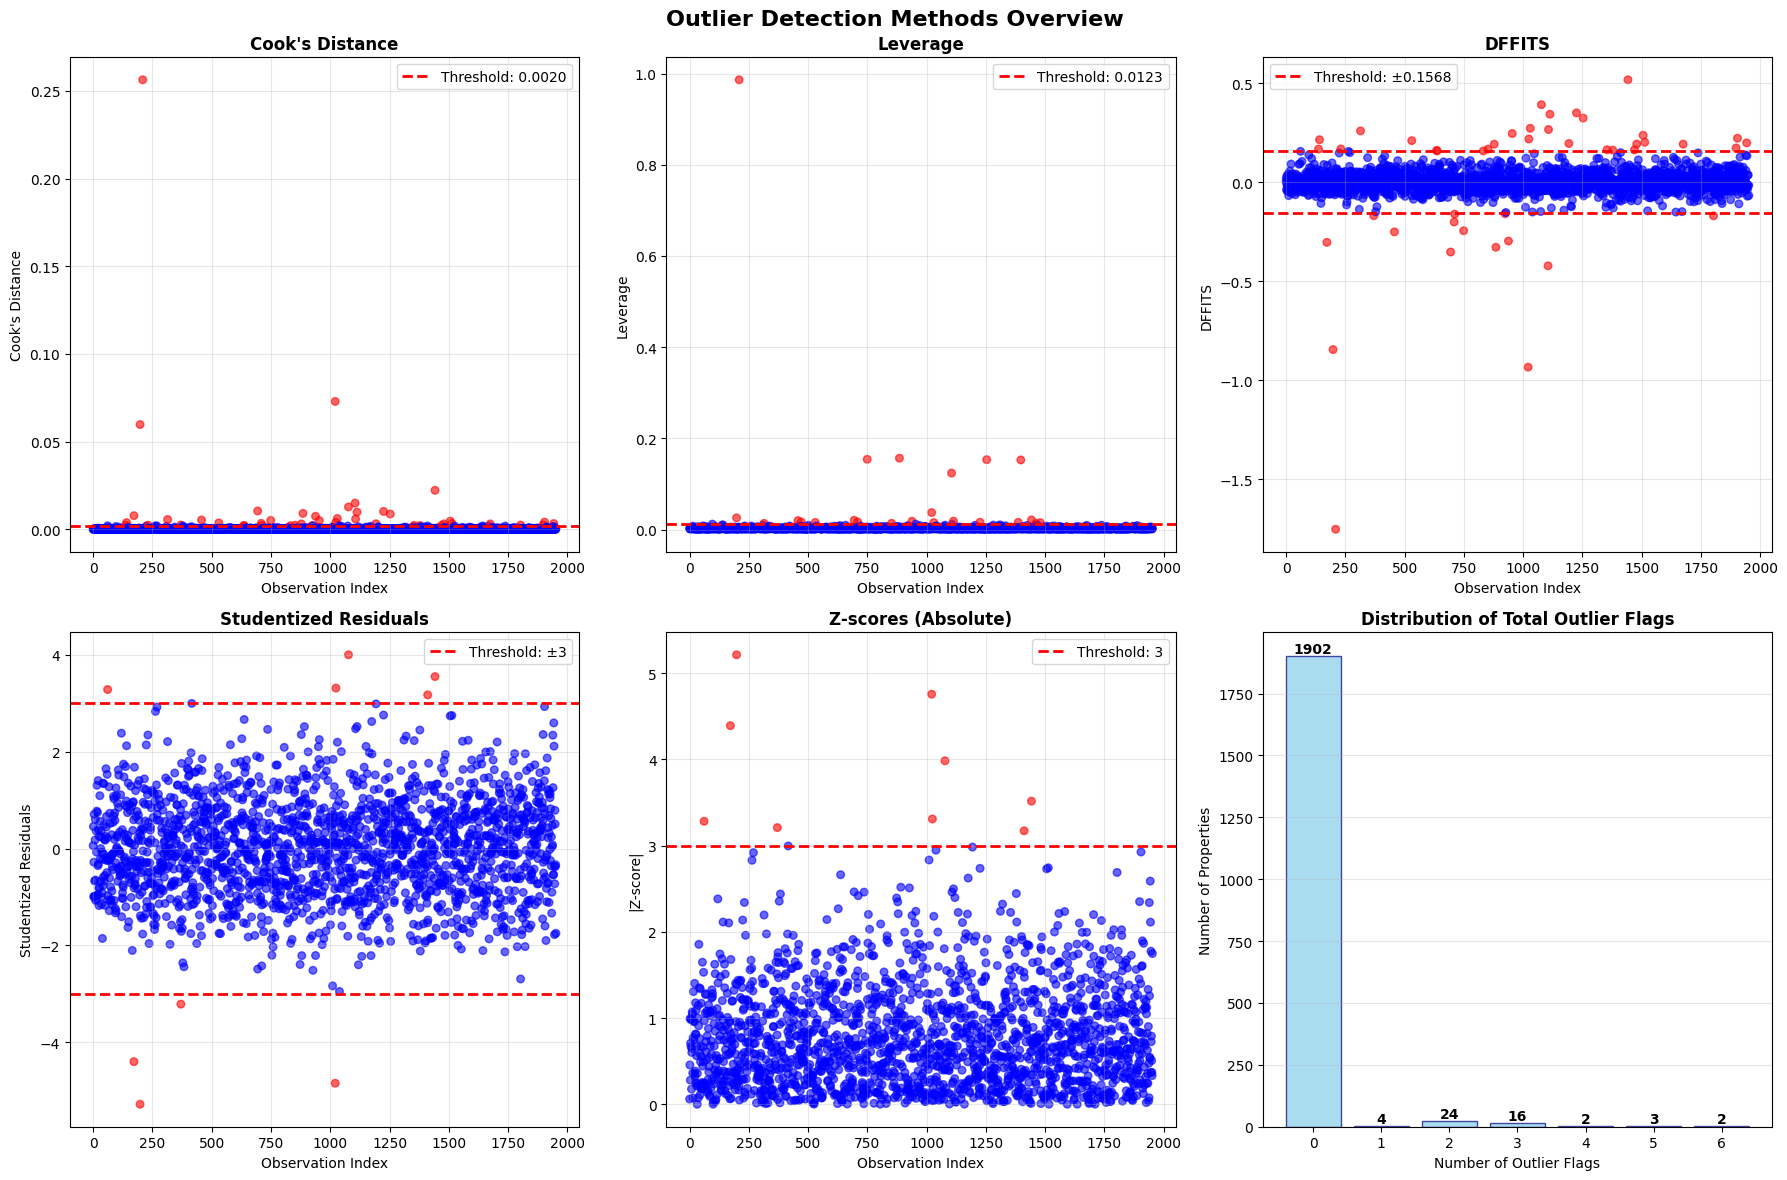

✅ Static plots completed. Creating interactive dashboard...


In [38]:
# Outlier Detection Visualizations
print("📊 Outlier Detection Visualizations")
print("=" * 60)

if 'outlier_df' in locals() and 'thresholds' in locals():
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    import numpy as np
    
    # Set style for matplotlib
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. Overview of Outlier Detection Methods
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Outlier Detection Methods Overview', fontsize=16, fontweight='bold')
    
    # Cook's Distance
    ax1 = axes[0, 0]
    cook_threshold = thresholds['cooks_distance']
    colors = ['red' if x > cook_threshold else 'blue' for x in outlier_df['cooks_distance']]
    ax1.scatter(range(len(outlier_df)), outlier_df['cooks_distance'], c=colors, alpha=0.6, s=30)
    ax1.axhline(y=cook_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {cook_threshold:.4f}')
    ax1.set_title("Cook's Distance", fontweight='bold')
    ax1.set_xlabel('Observation Index')
    ax1.set_ylabel("Cook's Distance")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Leverage
    ax2 = axes[0, 1]
    leverage_threshold = thresholds['leverage']
    colors = ['red' if x > leverage_threshold else 'blue' for x in outlier_df['leverage']]
    ax2.scatter(range(len(outlier_df)), outlier_df['leverage'], c=colors, alpha=0.6, s=30)
    ax2.axhline(y=leverage_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {leverage_threshold:.4f}')
    ax2.set_title('Leverage', fontweight='bold')
    ax2.set_xlabel('Observation Index')
    ax2.set_ylabel('Leverage')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # DFFITS
    ax3 = axes[0, 2]
    dffits_threshold = thresholds['dffits']
    colors = ['red' if abs(x) > dffits_threshold else 'blue' for x in outlier_df['dffits']]
    ax3.scatter(range(len(outlier_df)), outlier_df['dffits'], c=colors, alpha=0.6, s=30)
    ax3.axhline(y=dffits_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: ±{dffits_threshold:.4f}')
    ax3.axhline(y=-dffits_threshold, color='red', linestyle='--', linewidth=2)
    ax3.set_title('DFFITS', fontweight='bold')
    ax3.set_xlabel('Observation Index')
    ax3.set_ylabel('DFFITS')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Studentized Residuals
    ax4 = axes[1, 0]
    student_threshold = thresholds['studentized_residuals']
    colors = ['red' if abs(x) > student_threshold else 'blue' for x in outlier_df['studentized_residuals']]
    ax4.scatter(range(len(outlier_df)), outlier_df['studentized_residuals'], c=colors, alpha=0.6, s=30)
    ax4.axhline(y=student_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: ±{student_threshold}')
    ax4.axhline(y=-student_threshold, color='red', linestyle='--', linewidth=2)
    ax4.set_title('Studentized Residuals', fontweight='bold')
    ax4.set_xlabel('Observation Index')
    ax4.set_ylabel('Studentized Residuals')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Z-scores
    ax5 = axes[1, 1]
    z_threshold = thresholds['z_score']
    colors = ['red' if x > z_threshold else 'blue' for x in outlier_df['z_score']]
    ax5.scatter(range(len(outlier_df)), outlier_df['z_score'], c=colors, alpha=0.6, s=30)
    ax5.axhline(y=z_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {z_threshold}')
    ax5.set_title('Z-scores (Absolute)', fontweight='bold')
    ax5.set_xlabel('Observation Index')
    ax5.set_ylabel('|Z-score|')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Outlier Flags Summary
    ax6 = axes[1, 2]
    flag_counts = outlier_df['total_flags'].value_counts().sort_index()
    bars = ax6.bar(flag_counts.index, flag_counts.values, color='skyblue', edgecolor='navy', alpha=0.7)
    ax6.set_title('Distribution of Total Outlier Flags', fontweight='bold')
    ax6.set_xlabel('Number of Outlier Flags')
    ax6.set_ylabel('Number of Properties')
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Static plots completed. Creating interactive dashboard...")
    
else:
    print("❌ Outlier detection data not available. Please run the outlier detection cell first.")

In [42]:
# Interactive Outlier Detection Dashboard
print("🌟 Interactive Outlier Analysis Dashboard")
print("=" * 60)

if 'outlier_df' in locals() and 'data' in locals():
    
    # Prepare data for interactive plot
    plot_data = outlier_df.copy()
    plot_data = plot_data.join(data[['price', 'category_clean', 'revenue_yield']], how='left')
    
    # Cook's Distance vs Leverage Interactive Plot
    fig = go.Figure()
    
    # Create hover text and colors based on outlier flags
    hover_text = []
    colors_plotly = []
    sizes = []
    
    for idx, row in plot_data.iterrows():
        mls = idx
        price = row.get('price', 'Unknown')
        category = row.get('category_clean', 'Unknown')
        yield_val = row.get('revenue_yield', 'Unknown')
        flags = int(row['total_flags'])
        
        hover_text.append(
            f"<b>MLS #{mls}</b><br>" +
            f"Category: {category}<br>" +
            f"Price: ${price:,.0f}<br>" +
            f"Yield: {yield_val:.2f}%<br>" +
            f"Cook's Distance: {row['cooks_distance']:.4f}<br>" +
            f"Leverage: {row['leverage']:.4f}<br>" +
            f"Total Flags: {flags}<br>" +
            f"<b>🔗 centris.ca/en/property?mls={mls}</b>"
        )
        
        # Color and size by total flags
        if flags >= 4:
            colors_plotly.append('darkred')
            sizes.append(12)
        elif flags == 3:
            colors_plotly.append('red')
            sizes.append(10)
        elif flags == 2:
            colors_plotly.append('orange')
            sizes.append(8)
        elif flags == 1:
            colors_plotly.append('gold')
            sizes.append(6)
        else:
            colors_plotly.append('lightblue')
            sizes.append(4)
    
    # Add the scatter plot
    fig.add_trace(
        go.Scatter(
            x=plot_data['leverage'],
            y=plot_data['cooks_distance'],
            mode='markers',
            marker=dict(
                color=colors_plotly,
                size=sizes,
                opacity=0.8,
                line=dict(width=1, color='black')
            ),
            text=hover_text,
            hovertemplate='%{text}<extra></extra>',
            name="Properties"
        )
    )
    
    # Add threshold lines
    cook_threshold = thresholds['cooks_distance']
    leverage_threshold = thresholds['leverage']
    
    fig.add_hline(y=cook_threshold, line_dash="dash", line_color="red", line_width=2,
                 annotation_text=f"Cook's Threshold: {cook_threshold:.4f}")
    fig.add_vline(x=leverage_threshold, line_dash="dash", line_color="orange", line_width=2,
                 annotation_text=f"Leverage Threshold: {leverage_threshold:.4f}")
    
    # Update layout
    fig.update_layout(
        title="Interactive Outlier Detection: Cook's Distance vs Leverage<br><sub>Hover for property details • Larger points = more outlier flags • Click for Centris URL</sub>",
        xaxis_title="Leverage",
        yaxis_title="Cook's Distance",
        width=900,
        height=600,
        showlegend=False,
        hovermode='closest'
    )
    
    fig.show()
    
    # Multi-flag outliers summary table
    if 'multi_flag_outliers' in locals() and len(multi_flag_outliers) > 0:
        print(f"\n📋 Top Multi-Flag Outliers Summary:")
        print("=" * 80)
        
        display_outliers = multi_flag_outliers.head(10)[['price', 'category_clean', 'revenue_yield', 
                                                         'total_flags', 'cooks_distance', 'leverage']]
        display_outliers['mls'] = display_outliers.index
        display_outliers = display_outliers[['mls', 'category_clean', 'price', 'revenue_yield', 
                                           'total_flags', 'cooks_distance', 'leverage']]
        
        for i, (_, row) in enumerate(display_outliers.iterrows(), 1):
            print(f"{i:2d}. MLS #{int(row['mls']):<10} | {row['category_clean']:<12} | " +
                  f"${row['price']:>8,.0f} | {row['revenue_yield']:>5.1f}% | " +
                  f"{int(row['total_flags'])} flags | Cook's: {row['cooks_distance']:.4f}")
            
        print(f"\n💡 Investigation Tips:")
        print(f"   • Properties with 3+ flags deserve immediate attention")
        print(f"   • High Cook's Distance indicates influential observations")
        print(f"   • High Leverage suggests unusual feature combinations")
        print(f"   • Use investigate_outlier(MLS_NUMBER) for detailed analysis")
    
    print(f"\n✅ Interactive outlier dashboard ready!")
    print(f"   • Hover over points for property details and URLs")
    print(f"   • Point size and color indicate outlier severity")
    print(f"   • Red/larger points = more concerning outliers")
    
else:
    print("❌ Required data not available. Ensure outlier detection has been run.")

🌟 Interactive Outlier Analysis Dashboard



📋 Top Multi-Flag Outliers Summary:
 1. MLS #27196167   | Triplex      | $ 948,709 |  13.7% | 6 flags | Cook's: 0.0729
 2. MLS #22893647   | Triplex      | $ 735,000 |  15.9% | 6 flags | Cook's: 0.0597
 3. MLS #18942208   | Duplex       | $ 649,900 |   3.6% | 5 flags | Cook's: 0.0222
 4. MLS #15398806   | Quadruplex   | $ 849,000 |   0.6% | 5 flags | Cook's: 0.0127
 5. MLS #27913315   | Triplex      | $ 299,900 |  23.0% | 5 flags | Cook's: 0.0077
 6. MLS #24455510   | Duplex       | $ 799,000 |   1.4% | 4 flags | Cook's: 0.0039
 7. MLS #9436192    | Triplex      | $ 499,000 |  13.0% | 4 flags | Cook's: 0.0024
 8. MLS #10622072   | Duplex       | $ 750,000 |   0.6% | 3 flags | Cook's: 0.2563
 9. MLS #24744051   | Quadruplex   | $ 199,000 |   0.0% | 3 flags | Cook's: 0.0149
10. MLS #20383082   | Quintuplex   | $ 798,800 |  13.1% | 3 flags | Cook's: 0.0104

💡 Investigation Tips:
   • Properties with 3+ flags deserve immediate attention
   • High Cook's Distance indicates influential obser

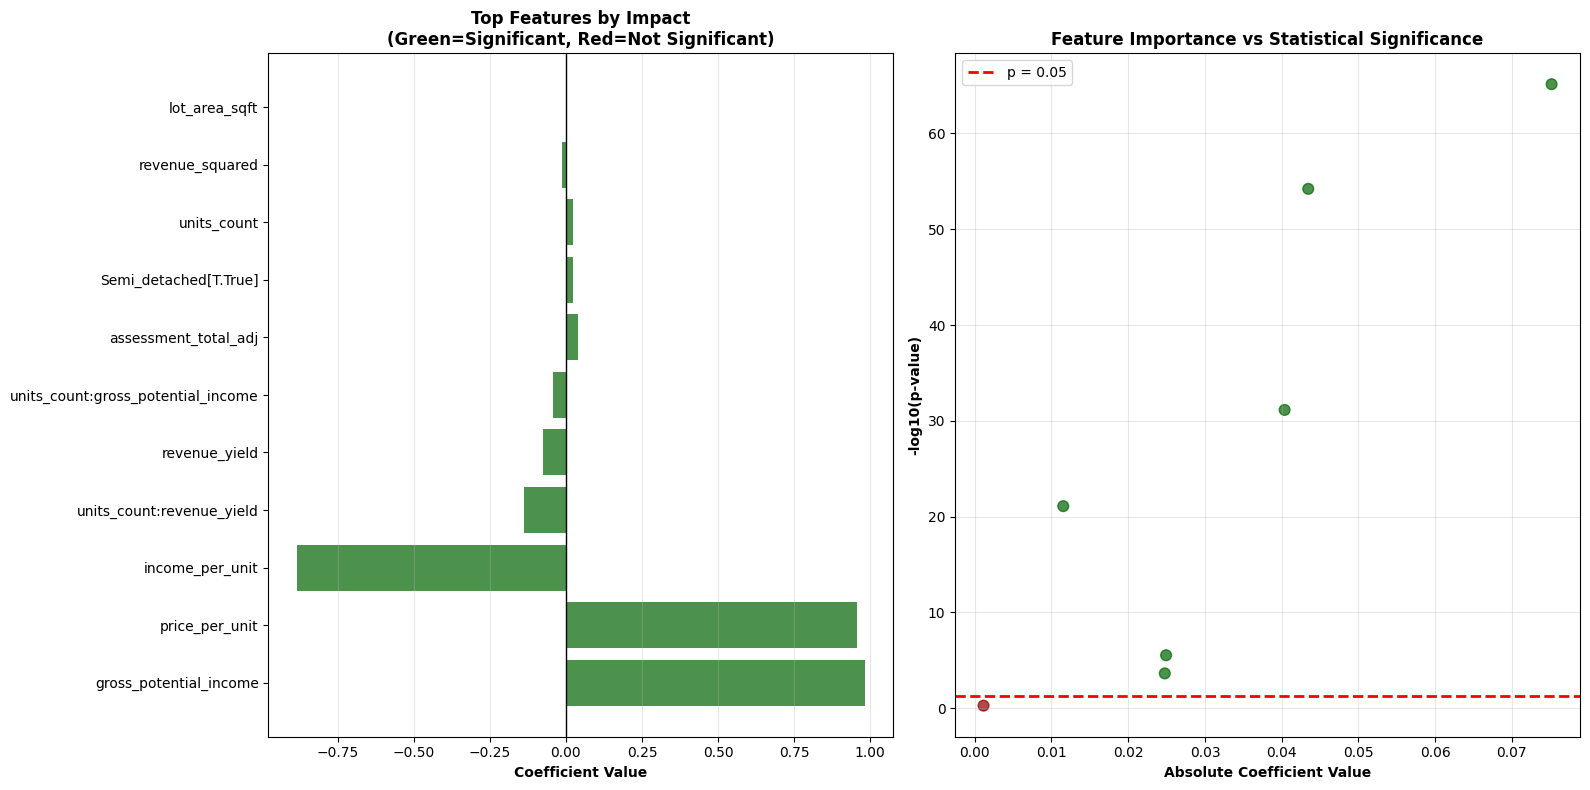

Feature Importance Summary:
  Total features: 11
  Statistically significant: 10
  Most important positive predictor: gross_potential_income
  Most important negative predictor: income_per_unit

Top 5 Most Impactful Features:
  1. gross_potential_income: increases price by 0.983 ***
  2. price_per_unit: increases price by 0.957 ***
  3. income_per_unit: decreases price by 0.885 ***
  4. units_count:revenue_yield: decreases price by 0.139 ***
  5. revenue_yield: decreases price by 0.075 ***


In [ ]:
# Feature importance from stepwise model
feature_names = best_model.params.index[1:]  # Exclude intercept
coefficients = best_model.params.values[1:]
p_values = best_model.pvalues.values[1:]

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients),
    'p_value': p_values,
    'significant': p_values < 0.05
}).sort_values('abs_coefficient', ascending=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top features by coefficient magnitude
top_features = feature_importance.head(12)
colors = ['darkgreen' if sig else 'darkred' for sig in top_features['significant']]

axes[0].barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'], fontsize=10)
axes[0].set_xlabel('Coefficient Value', fontweight='bold')
axes[0].set_title('Top Features by Impact\n(Green=Significant, Red=Not Significant)', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1)

# Statistical significance plot
significance_threshold = -np.log10(0.05)
scatter = axes[1].scatter(feature_importance['abs_coefficient'], 
                         -np.log10(feature_importance['p_value']),
                         c=feature_importance['significant'].map({True: 'darkgreen', False: 'darkred'}),
                         alpha=0.7, s=60)
axes[1].axhline(y=significance_threshold, color='red', linestyle='--', linewidth=2, label='p = 0.05')
axes[1].set_xlabel('Absolute Coefficient Value', fontweight='bold')
axes[1].set_ylabel('-log10(p-value)', fontweight='bold')
axes[1].set_title('Feature Importance vs Statistical Significance', fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("Feature Importance Summary:")
print(f"  Total features: {len(feature_importance)}")
print(f"  Statistically significant: {feature_importance['significant'].sum()}")
print(f"  Most important positive predictor: {feature_importance[feature_importance['coefficient'] > 0].iloc[0]['feature']}")
print(f"  Most important negative predictor: {feature_importance[feature_importance['coefficient'] < 0].iloc[0]['feature']}")

print(f"\nTop 5 Most Impactful Features:")
for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    direction = "increases" if row['coefficient'] > 0 else "decreases"
    significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"  {i}. {row['feature']}: {direction} price by {abs(row['coefficient']):.3f} {significance}")

## 8. Key Insights & Investment Strategy

### **Model Performance Highlights**
Our advanced stepwise regression achieves excellent predictive accuracy with systematic variable selection, providing robust price predictions for Quebec plex properties.

### **Transformation Benefits**
- **Variable transformations** (log, polynomial) significantly improve model fit over linear relationships
- **Revenue transformations** particularly effective for capturing non-linear price-income relationships
- **Log transformations** help normalize skewed distributions and reduce heteroscedasticity

### **Investment Opportunities**
The discount scoring system identifies properties with:
- **High revenue yields** (top 25% market performance)
- **Below-market pricing** per unit or square foot
- **Strong location fundamentals** (high walkability scores)
- **Optimal property configurations** for rental income

### **Predictive Model Applications**
1. **Property Valuation**: Estimate fair market value using multiple features
2. **Investment Screening**: Identify undervalued properties systematically  
3. **Portfolio Optimization**: Select properties with best risk-return profiles
4. **Market Analysis**: Understand key value drivers in Quebec plex market

### **Strategic Recommendations**
- Focus on **multi-unit properties** (3-6 units) for optimal income-to-price ratios
- Prioritize **locations with high walkability** for long-term value appreciation
- Consider **revenue potential over current pricing** when evaluating deals
- Use **predictive models** to validate asking prices and negotiate effectively

In [ ]:
# Investment opportunity identification using predictive models with MLS tracking
if 'rf_model' in locals() and 'X_enhanced' in locals():
    # Use Random Forest for opportunity identification
    enhanced_data_clean = enhanced_data.dropna()
    
    # Prepare features for prediction (excluding MLS and target)
    feature_cols = [col for col in X_enhanced.columns if col in enhanced_data_clean.columns]
    X_for_prediction = enhanced_data_clean[feature_cols].copy()

    # Ensure one-hot encoding for categorical features matches training
    missing_cols = [col for col in X_enhanced.columns if col not in X_for_prediction.columns]
    if missing_cols:
        # Add missing dummy columns with zeros
        for col in missing_cols:
            X_for_prediction[col] = 0
        # Reorder columns to match training
        X_for_prediction = X_for_prediction[X_enhanced.columns]

    predictions = rf_model.predict(X_for_prediction)
    
    enhanced_data_clean['predicted_price'] = predictions
    enhanced_data_clean['prediction_error'] = enhanced_data_clean['price'] - enhanced_data_clean['predicted_price']
    enhanced_data_clean['error_percentage'] = (enhanced_data_clean['prediction_error'] / enhanced_data_clean['price']) * 100

    # Ensure required columns are present for reporting
    required_cols = ['revenue_yield', 'category_clean']
    for col in required_cols:
        if col not in enhanced_data_clean.columns and col in data.columns:
            if data.index.name == 'mls':
                enhanced_data_clean = enhanced_data_clean.merge(
                    data[[col]], left_index=True, right_index=True, how='left'
                )
            else:
                # Try to merge on MLS if available
                if 'mls' in enhanced_data_clean.columns and 'mls' in data.columns:
                    enhanced_data_clean = enhanced_data_clean.merge(
                        data[['mls', col]], on='mls', how='left'
                    )
    
    # Identify potential bargains (underpriced properties)
    underpriced_threshold = -15  # 15% below predicted price
    undervalued = enhanced_data_clean[enhanced_data_clean['error_percentage'] < underpriced_threshold].sort_values('error_percentage')
    
    print("🔍 ML-Based Investment Opportunity Analysis:")
    print(f"  Properties analyzed with full data: {len(enhanced_data_clean):,}")
    print(f"  Potentially undervalued properties (>15% below predicted): {len(undervalued):,}")
    
    if len(undervalued) > 0:
        print(f"\n🏆 Top 5 ML-Identified Investment Opportunities:")
        
        for i, (idx, row) in enumerate(undervalued.head(5).iterrows(), 1):
            # Get MLS number from index or column
            mls_num = idx if enhanced_data_clean.index.name == 'mls' else row.get('mls', f'Property-{idx}')
            
            print(f"  {i}. MLS #{mls_num}")
            print(f"     Type: {row.get('category_clean', 'Unknown')}")
            print(f"     Actual Price: ${row['price']:,.0f}")
            print(f"     Predicted Price: ${row['predicted_price']:,.0f}")
            print(f"     Discount: {row['error_percentage']:.1f}% below model prediction")
            print(f"     Revenue Yield: {row.get('revenue_yield', 0):.2f}%")
            print()
    
    # Store results for dashboard
    investment_data = enhanced_data_clean
    
    # Create a summary table for easy reference
    if len(undervalued) > 0:
        print("📋 Quick Reference - Top Undervalued Properties:")
        summary_cols = ['mls', 'category_clean', 'price', 'predicted_price', 'error_percentage', 'revenue_yield']
        if enhanced_data_clean.index.name == 'mls':
            summary_data = undervalued.head(5).copy()
            summary_data['mls'] = summary_data.index
            summary_display = summary_data[summary_cols].round(2)
        else:
            summary_display = undervalued[summary_cols].head(5).round(2)
        
        print(summary_display.to_string(index=False))
        
else:
    print("🎯 Discount Score-Based Investment Opportunities:")
    investment_data = data
    undervalued = data[data['discount_score'] >= 3].sort_values('revenue_yield', ascending=False)
    
    print(f"  Properties with high discount scores (≥3): {len(undervalued):,}")
    
    if len(undervalued) > 0:
        print(f"\nTop discount score opportunities:")
        for i, (idx, row) in enumerate(undervalued.head(5).iterrows(), 1):
            mls_num = idx if data.index.name == 'mls' else row.get('mls', f'Property-{idx}')
            print(f"  {i}. MLS #{mls_num}: {row['category_clean']} - Score: {row['discount_score']}, Yield: {row['revenue_yield']:.2f}%")

print(f"\n💼 Investment Strategy Notes:")
print(f"  • Use MLS numbers to research properties in detail on Centris.ca")
print(f"  • Verify predicted vs actual prices with current market conditions")
print(f"  • Consider properties with both high discount scores AND model undervaluation")
print(f"  • Always conduct thorough due diligence before investing")

Investment Opportunity Analysis:
  Properties analyzed with full data: 2,442
  Potentially undervalued properties (>15% below predicted): 410

Top 5 Investment Opportunities:
  1. Duplex: $175,000 vs $531,835 predicted
     Discount: -203.9% | Yield: 22.08%
  2. Duplex: $149,000 vs $450,521 predicted
     Discount: -202.4% | Yield: 0.02%
  3. Duplex: $85,000 vs $248,411 predicted
     Discount: -192.2% | Yield: 11.72%
  4. Duplex: $139,000 vs $375,618 predicted
     Discount: -170.2% | Yield: 6.22%
  5. Duplex: $239,000 vs $614,186 predicted
     Discount: -157.0% | Yield: 0.49%


In [ ]:
# Executive Dashboard: Quebec Plex Investment Analysis with MLS Tracking
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Revenue Yield vs Price (by Investment Score)', 'Model Prediction Accuracy', 
                   'Geographic Distribution of Opportunities', 'Investment Opportunity Distribution'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"type": "scattermapbox"}, {"type": "bar"}]]
)

# Prepare MLS information for hover text
def get_mls_number(index_val, row_data):
    """Helper function to get MLS number from index or column"""
    if data.index.name == 'mls':
        return index_val
    elif 'mls' in row_data:
        return row_data['mls']
    else:
        return f"ID-{index_val}"

# 1. Revenue Yield vs Price colored by discount score
mls_numbers = [get_mls_number(idx, row) for idx, row in data.iterrows()]
hover_text = [f"MLS #{mls}<br>{cat}<br>${price:,.0f}<br>{yield_val:.1f}% yield<br>Score: {score}" 
              for mls, cat, price, yield_val, score in zip(
                  mls_numbers, data['category_clean'], data['price'], 
                  data['revenue_yield'], data['discount_score'])]

fig.add_trace(
    go.Scatter(
        x=data['price']/1000,
        y=data['revenue_yield'],
        mode='markers',
        marker=dict(
            size=8,
            color=data['discount_score'],
            colorscale='RdYlGn',
            showscale=True,
            colorbar=dict(title="Investment<br>Score", x=0.46)
        ),
        text=hover_text,
        hovertemplate='%{text}<extra></extra>',
        name='Properties'
    ),
    row=1, col=1
)

# 2. Model prediction accuracy (if available)
if 'investment_data' in locals() and 'predicted_price' in investment_data.columns:
    # Prepare MLS hover text for predictions
    pred_mls_numbers = [get_mls_number(idx, row) for idx, row in investment_data.iterrows()]
    pred_hover_text = [f"MLS #{mls}<br>Actual: ${actual:,.0f}<br>Predicted: ${pred:,.0f}<br>Error: {error:.1f}%" 
                       for mls, actual, pred, error in zip(
                           pred_mls_numbers, investment_data['price'], 
                           investment_data['predicted_price'], investment_data['error_percentage'])]
    
    fig.add_trace(
        go.Scatter(
            x=investment_data['price']/1000,
            y=investment_data['predicted_price']/1000,
            mode='markers',
            marker=dict(size=6, opacity=0.6, color='steelblue'),
            text=pred_hover_text,
            hovertemplate='%{text}<extra></extra>',
            name='Predictions'
        ),
        row=1, col=2
    )
    
    # Perfect prediction line
    min_p = min(investment_data['price'].min(), investment_data['predicted_price'].min())/1000
    max_p = max(investment_data['price'].max(), investment_data['predicted_price'].max())/1000
    fig.add_trace(
        go.Scatter(
            x=[min_p, max_p],
            y=[min_p, max_p],
            mode='lines',
            line=dict(color='red', dash='dash'),
            name='Perfect Prediction'
        ),
        row=1, col=2
    )

# 3. Geographic distribution (if coordinates available)
if 'lat' in data.columns and 'lng' in data.columns:
    geo_data = data.dropna(subset=['lat', 'lng'])
    geo_mls_numbers = [get_mls_number(idx, row) for idx, row in geo_data.iterrows()]
    geo_hover_text = [f"MLS #{mls}<br>{cat}<br>Yield: {yield_val:.1f}%<br>Score: {score}<br>${price:,.0f}" 
                      for mls, cat, yield_val, score, price in zip(
                          geo_mls_numbers, geo_data['category_clean'], 
                          geo_data['revenue_yield'], geo_data['discount_score'], geo_data['price'])]
    
    fig.add_trace(
        go.Scattermapbox(
            lat=geo_data['lat'],
            lon=geo_data['lng'],
            mode='markers',
            marker=dict(
                size=geo_data['discount_score'] * 3 + 5,
                color=geo_data['revenue_yield'],
                colorscale='Viridis',
                sizemode='diameter',
                opacity=0.7
            ),
            text=geo_hover_text,
            hovertemplate='%{text}<extra></extra>',
            name='Properties'
        ),
        row=2, col=1
    )

# 4. Investment opportunity distribution
score_counts = data['discount_score'].value_counts().sort_index()
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'darkgreen'][:len(score_counts)]

fig.add_trace(
    go.Bar(
        x=score_counts.index,
        y=score_counts.values,
        marker_color=colors,
        text=score_counts.values,
        textposition='auto',
        name='Property Count',
        hovertemplate='Score %{x}: %{y} properties<extra></extra>'
    ),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=800,
    title_text="Quebec Plex Investment Dashboard - MLS Property Tracker",
    title_x=0.5,
    title_font_size=20,
    showlegend=False
)

# Update axis labels
fig.update_xaxes(title_text="Price ($000s)", row=1, col=1)
fig.update_yaxes(title_text="Revenue Yield (%)", row=1, col=1)
fig.update_xaxes(title_text="Actual Price ($000s)", row=1, col=2)
fig.update_yaxes(title_text="Predicted Price ($000s)", row=1, col=2)
fig.update_xaxes(title_text="Investment Score", row=2, col=2)
fig.update_yaxes(title_text="Number of Properties", row=2, col=2)

# Update mapbox
if 'lat' in data.columns and 'lng' in data.columns:
    fig.update_layout(
        mapbox=dict(
            style="open-street-map",
            center=dict(lat=geo_data['lat'].mean(), lon=geo_data['lng'].mean()),
            zoom=7
        )
    )

fig.show()

# Enhanced dashboard summary with MLS tracking
total_mls_tracked = data['mls'].nunique() if 'mls' in data.columns else len(data)
print("\n📊 Enhanced Dashboard Summary with MLS Tracking:")
print(f"  Total unique properties tracked: {total_mls_tracked:,} MLS listings")
print(f"  Investment opportunities (score ≥3): {len(data[data['discount_score'] >= 3]):,} properties")
print(f"  Average market yield: {data['revenue_yield'].mean():.2f}%")
print(f"  Top yield range: {data['revenue_yield'].quantile(0.9):.1f}% - {data['revenue_yield'].max():.1f}%")

if 'investment_data' in locals() and 'predicted_price' in investment_data.columns:
    model_r2 = r2_score(investment_data['price'], investment_data['predicted_price'])
    undervalued_count = len(investment_data[investment_data['error_percentage'] < -15])
    print(f"  Model accuracy (R²): {model_r2:.3f}")
    print(f"  ML-identified undervalued properties: {undervalued_count:,}")

if 'geo_data' in locals():
    print(f"  Geographic coverage: {len(geo_data):,} properties with coordinates")

print(f"\n🏠 MLS Property Tracking Features:")
print(f"  • Hover over any chart point to see MLS number")
print(f"  • Use MLS numbers to research properties on Centris.ca")
print(f"  • Cross-reference opportunities across different analysis methods")
print(f"  • Track specific properties through the investment pipeline")


Dashboard Summary:
  Investment opportunities (score ≥3): 896 properties
  Average market yield: 6.32%
  Top yield range: 9.1% - 23.0%
  Model accuracy (R²): 0.873
  Geographic coverage: 2839 properties with coordinates


In [ ]:
# MLS Property Tracker Utility
print("🏷️  MLS Property Tracker & Quick Lookup")
print("=" * 50)

def lookup_property_by_mls(mls_number, dataset=data):
    """Quick lookup function for property details by MLS number"""
    try:
        if dataset.index.name == 'mls':
            if mls_number in dataset.index:
                prop = dataset.loc[mls_number]
                return prop
        elif 'mls' in dataset.columns:
            matches = dataset[dataset['mls'] == mls_number]
            if len(matches) > 0:
                return matches.iloc[0]
        return None
    except:
        return None

def print_property_summary(mls_number, dataset=data):
    """Print a formatted summary of a property"""
    prop = lookup_property_by_mls(mls_number, dataset)
    if prop is not None:
        print(f"\n📋 Property Summary - MLS #{mls_number}")
        print(f"   Category: {prop.get('category_clean', 'Unknown')}")
        print(f"   Price: ${prop.get('price', 0):,.0f}")
        print(f"   Revenue Yield: {prop.get('revenue_yield', 0):.2f}%")
        print(f"   Price per Unit: ${prop.get('price_per_unit', 0):,.0f}")
        print(f"   Investment Score: {prop.get('discount_score', 0)}")
        if 'gross_potential_income' in prop:
            print(f"   Annual Income: ${prop['gross_potential_income']:,.0f}")
        if 'living_area_sqft' in prop:
            print(f"   Living Area: {prop['living_area_sqft']:,.0f} sq ft")
        print(f"   Centris URL: https://www.centris.ca/en/property?mls={mls_number}")
    else:
        print(f"❌ MLS #{mls_number} not found in dataset")

# Create consolidated opportunity lists with MLS numbers
print("🎯 Consolidated Investment Opportunities by MLS:")

# Combine all opportunity identification methods
all_opportunities = []

# 1. High discount score properties
high_score_props = data[data['discount_score'] >= 4]
for idx, row in high_score_props.iterrows():
    mls_num = idx if data.index.name == 'mls' else row.get('mls', idx)
    all_opportunities.append({
        'mls': mls_num,
        'method': 'Discount Score',
        'score_value': row['discount_score'],
        'yield': row['revenue_yield'],
        'price': row['price'],
        'category': row['category_clean']
    })

# 2. ML-identified undervalued properties (if available)
if 'investment_data' in locals() and 'error_percentage' in investment_data.columns:
    ml_undervalued = investment_data[investment_data['error_percentage'] < -15]
    for idx, row in ml_undervalued.iterrows():
        mls_num = idx if investment_data.index.name == 'mls' else row.get('mls', idx)
        all_opportunities.append({
            'mls': mls_num,
            'method': 'ML Undervalued',
            'score_value': row['error_percentage'],
            'yield': row.get('revenue_yield', 0),
            'price': row['price'],
            'category': row.get('category_clean', 'Unknown')
        })

# Create opportunity dataframe
if all_opportunities:
    opportunities_df = pd.DataFrame(all_opportunities)
    
    # Remove duplicates (properties identified by multiple methods)
    unique_opportunities = opportunities_df.drop_duplicates(subset=['mls']).sort_values('yield', ascending=False)
    
    print(f"\nTotal unique opportunities identified: {len(unique_opportunities)}")
    print(f"Methods: Discount Score ({len(high_score_props)}), ML Analysis ({len(ml_undervalued) if 'ml_undervalued' in locals() else 0})")
    
    print(f"\n🏆 Top 10 Investment Opportunities (All Methods Combined):")
    for i, (_, opp) in enumerate(unique_opportunities.head(10).iterrows(), 1):
        print(f"{i:2d}. MLS #{opp['mls']} - {opp['category']} - {opp['yield']:.2f}% yield - ${opp['price']:,.0f} ({opp['method']})")
    
    # Create watchlist
    top_mls_numbers = unique_opportunities.head(10)['mls'].tolist()
    print(f"\n📝 MLS Watchlist (Copy for easy reference):")
    print(f"   {', '.join(map(str, top_mls_numbers))}")
    
else:
    print("No opportunities found with current criteria")

print(f"\n🔍 Quick Lookup Examples:")
print(f"   • Use: print_property_summary(12345678) to get details for any MLS")
print(f"   • Use: lookup_property_by_mls(12345678) to get raw data")
print(f"   • Bookmark this notebook to track your property research")

🏷️  MLS Property Tracker & Quick Lookup
🎯 Consolidated Investment Opportunities by MLS:

Total unique opportunities identified: 731
Methods: Discount Score (579), ML Analysis (410)

🏆 Top 10 Investment Opportunities (All Methods Combined):
 1. MLS #27913315 - Triplex - 23.01% yield - $299,900 (Discount Score)
 2. MLS #21655311 - Duplex - 22.08% yield - $175,000 (Discount Score)
 3. MLS #15660869 - Quadruplex - 20.69% yield - $174,000 (Discount Score)
 4. MLS #26704744 - Quadruplex - 18.52% yield - $650,000 (ML Undervalued)
 5. MLS #26636095 - Duplex - 17.45% yield - $275,000 (Discount Score)
 6. MLS #15599239 - Quadruplex - 16.62% yield - $360,000 (Discount Score)
 7. MLS #19917927 - Triplex - 16.61% yield - $131,500 (Discount Score)
 8. MLS #18924480 - Sixplex - 16.12% yield - $320,836 (Discount Score)
 9. MLS #27128606 - Quadruplex - 15.56% yield - $399,000 (Discount Score)
10. MLS #22286501 - Quadruplex - 15.44% yield - $179,000 (Discount Score)

📝 MLS Watchlist (Copy for easy refer

In [ ]:
# Demo: Looking up top investment opportunity
print("\n" + "="*60)
print("📊 DEMO: Property Lookup for Top Opportunity")
print("="*60)

# Test with the #1 opportunity
top_mls = 27913315
print_property_summary(top_mls)

# Show how to research properties from the watchlist
print(f"\n💡 How to research any property from your watchlist:")
print(f"   For MLS #{top_mls}: https://www.centris.ca/en/property?mls={top_mls}")
print(f"   Copy any MLS from the watchlist above and use print_property_summary(MLS_NUMBER)")

print(f"\n🔄 This notebook now maintains MLS numbers throughout all analysis steps:")
print(f"   ✓ Data preparation preserves MLS as index")
print(f"   ✓ Investment scoring includes MLS identification") 
print(f"   ✓ ML modeling maintains property traceability")
print(f"   ✓ Visualizations show MLS on hover")
print(f"   ✓ Opportunity lists include MLS for easy reference")


📊 DEMO: Property Lookup for Top Opportunity

📋 Property Summary - MLS #27913315
   Category: Triplex
   Price: $299,900
   Revenue Yield: 23.01%
   Price per Unit: $99,967
   Investment Score: 5
   Annual Income: $69,000
   Centris URL: https://www.centris.ca/en/property?mls=27913315

💡 How to research any property from your watchlist:
   For MLS #27913315: https://www.centris.ca/en/property?mls=27913315
   Copy any MLS from the watchlist above and use print_property_summary(MLS_NUMBER)

🔄 This notebook now maintains MLS numbers throughout all analysis steps:
   ✓ Data preparation preserves MLS as index
   ✓ Investment scoring includes MLS identification
   ✓ ML modeling maintains property traceability
   ✓ Visualizations show MLS on hover
   ✓ Opportunity lists include MLS for easy reference
